In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import itertools
import warnings
warnings.filterwarnings('ignore')

from src.geo import *
from src.stations import Stations
from src.filters import median_filter
from src.track import Track, TrackCollection
from src.solvers import *

from optimize import *

from tqdm import tqdm
from collections import defaultdict
import json
import os

from sklearn.linear_model import RANSACRegressor


%matplotlib inline

In [ ]:
## Synchronize stations 14 and 150

### Download training1 in order to get combination (14, 150) from it

In [3]:
df = pd.read_csv('round2/round2_training1.csv')
tracks = TrackCollection(df)

100%|██████████| 2888/2888 [06:52<00:00,  7.00it/s] 


In [3]:
# Information about sensors

sensors = pd.read_csv('round2/round2_sensors.csv')
good_sensors = sensors[sensors.good==True].serial.values

# 
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]

st = Stations([14, 150])
st.A0 = A0_B[0]
st.B = A0_B[1]
st.set_time_correction(14, shift=pow(10, -7.22819731e+00))
st.update_location(14, [47.2482948, 8.52974042, 625.144672])
st

AttributeError: 'Stations' object has no attribute 'set_time_correction'

In [12]:
gss = GoodStationsSolver()
gss.prepare_data(tracks, st, threshold=1500*1e-9, N=10000)

100%|██████████| 2/2 [00:00<00:00, 562.43it/s]


In [15]:
len(gss.points['t1'])

282

In [16]:
gss.optimize(st, A0_B[0], A0_B[1], [-7.22819731e+00]*2, optimize_locations_flag=False)

(array([-7.40125063, -7.03697761]), 13.56834792159379)


In [21]:
shift_150 = gss.result[0] - gss.result[0][0] - 7.22819731e+00
shift_150 = shift_150[1]
st.set_time_correction(150, shift=pow(10, shift_150))

30.48936036975647


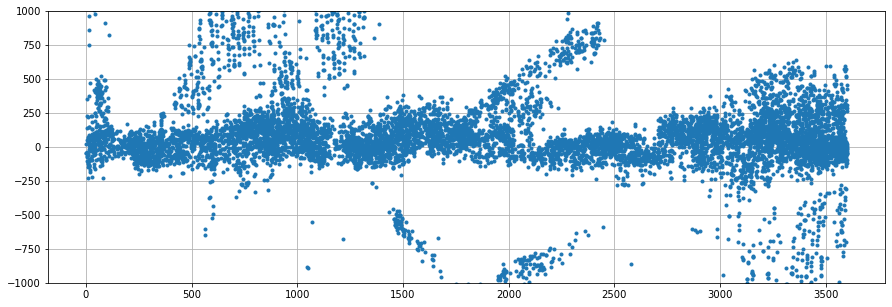

In [40]:
### Check synchronization of good stations
comb = (14, 150)

_, tel = tracks.aggregate(comb, return_telemetry=True, return_time=True)

st1, st2 = comb
st1_str, st2_str = str(comb[0]), str(comb[1])

output = np.zeros([tel.shape[0], 2])
        
p3 = [P3(lat, lon, hgt) for lat, lon, hgt in zip(tel['latitude'], tel['longitude'], tel['geoAltitude'])]
        
t1 = st.correct_time(st1, tel[st1_str].values)
t2 = st.correct_time(st2, tel[st2_str].values)
        
output[:, 0] = np.array([t - st.time_to(st1, p) for t, p in zip(t1, p3)])
output[:, 1] = np.array([t - st.time_to(st2, p) for t, p in zip(t2, p3)])

print(3e8*np.median(np.fabs(output[:, 0] - output[:, 1])))

figsize(15, 5)
plt.plot(output[:, 0], 1e9*(output[:, 0] - output[:, 1]), '.')
plt.ylim([-1e3, 1e3])
plt.grid()

In [26]:
print(shift_150)

-6.863924290039169


In [ ]:
#### Synchronize all stations

In [3]:
## All data
df = (pd.read_csv('round2/round2_competition.csv')
      .assign(test = lambda x: x.latitude.apply(lambda y: int(np.isnan(y))))
      .loc[lambda x: x.test==0]
      .reset_index(drop=True)
     )

tracks = TrackCollection(df)

100%|██████████| 2629/2629 [07:30<00:00,  5.84it/s]


In [4]:
sensors = pd.read_csv('round2/round2_sensors.csv')
good_sensors = sensors[sensors.good==True].serial.values

first_set = list(set(good_sensors).difference([175, 532, 319, 201, 131, 150, 132, 142, 135, 187]))

In [5]:
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]
        
shifts = [pow(10, y) for y in [-7.11434081e+00, -7.22819731e+00,
       -8.83870731e+00, -7.06997492e+00, -7.08268100e+00, -7.00938609e+00,
       -1.01729574e+01, -9.77355387e+00, -7.11141541e+00, -6.76659381e+00,
       -7.22278746e+00, -6.92709914e+00, -7.03996985e+00, -7.75427061e+00,
       -9.11757476e+00, -6.89056754e+00, -9.46801783e+00, -7.21695015e+00,
       -7.33769829e+00, -6.91792998e+00, -7.36301447e+00, -8.56531160e+00,
       -6.75218732e+00, -3.91861080e+00, -3.91835193e+00, -3.91807496e+00,
       -3.91839432e+00, -3.91839479e+00, -6.81686631e+00, -6.82750234e+00,
       -6.72162050e+00, -7.12386142e+00, -7.05804971e+00, -6.96517205e+00,
       -8.76157876e+00]]
        
locations = [4.74003907e+01,  8.63053167e+00,  4.30683845e+02,
        4.72482948e+01,  8.52974042e+00,  6.25144672e+02,  4.70704381e+01,
        7.62059643e+00,  5.60811656e+02,  4.75381564e+01,  7.55951888e+00,
        3.52785754e+02,  4.94248656e+01,  7.75277186e+00,  2.92222132e+02,
        4.60500229e+01,  1.44691210e+01,  3.46882083e+02,  5.09371903e+01,
        7.35395305e+00,  2.62305822e+02,  3.86893683e+01, -9.35489820e+00,
        7.37338821e+01,  4.65138771e+01,  1.51881293e+01,  1.57734454e+03,
        4.75119828e+01,  1.02801412e+01,  7.54540937e+02,  4.83658601e+01,
        1.14784277e+01,  4.92925814e+02,  4.70361216e+01,  8.32399853e+00,
        4.79550824e+02,  4.81787456e+01,  1.22354460e+01,  5.29391996e+02,
        5.27809770e+01, -1.20441490e+00,  4.27620402e+01,  5.18724544e+01,
       -5.06989464e-01,  1.81262795e+02,  5.14865736e+01,  7.59784956e+00,
        1.46600666e+02,  4.95296172e+01,  1.09061941e+01,  3.06901503e+02,
        4.88913513e+01,  9.17767383e+00,  3.03714814e+02,  5.12458814e+01,
       -7.68625186e-01,  1.08587905e+02,  4.86569294e+01,  8.72482551e+00,
        3.60914642e+02,  5.18331813e+01,  4.14276178e+00,  1.09823167e+01,
        5.12427012e+01,  6.68497250e+00,  4.39053786e+01,  3.71713545e+01,
       -7.52168839e+00,  6.65337662e+01,  4.92876342e+01,  7.60384112e+00,
        4.10653429e+02,  4.94716113e+01,  7.69651939e+00,  2.67632204e+02,
        4.67624871e+01,  7.60048572e+00,  5.90875517e+02,  4.73778257e+01,
        8.55247058e+00,  5.03952969e+02,  5.02060722e+01,  6.97846214e+00,
        4.34708535e+02,  3.92316619e+01, -9.30812764e+00,  6.39646694e+01,
        4.01651070e+01, -8.19932381e+00,  1.80718597e+02,  3.89892473e+01,
       -7.15020320e+00,  2.41443914e+02,  4.87109833e+01,  9.26528906e+00,
        3.55448500e+02,  4.70362217e+01,  8.32402692e+00,  4.61417533e+02,
        4.99882346e+01,  8.59180901e+00,  1.34775358e+02,  5.13416634e+01,
        5.89330577e+00,  3.13178694e+01]

In [6]:
fst = Stations(first_set)

fst.A0 = A0_B[0]
fst.B = A0_B[1]

st_params = {}

for i, s in enumerate(fst.inventory):
    st_params[str(s)] = {'location': locations[3*i:3*i+3],
                         'shift':shifts[i]}
    
## add station 150
fst.add_station(150)
st_params['150'] = {'location': sensors[sensors.serial==150][['latitude', 'longitude', 'height']].values[0].tolist(),
                    'shift':pow(10, -6.863924290039169)}

with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

for s in st_params:
    fst.update_location(int(s), st_params[s]['location'])
    
fst.st_params = st_params

fst

Stations: 10, 14, 121, 124, 130, 133, 134, 136, 138, 141, 143, 147, 149, 150, 208, 216, 247, 257, 263, 294, 299, 327, 398, 402, 414, 460, 470, 474, 550, 564, 568, 569, 598, 632, 663, 670

In [8]:
## from prev run
bad = [205, 259, 296, 222, 207, 695, 700, 525, 699, 461, 605, 295, 671, 377, 577, 641, 312, 702, 214, 635, 281, 477, 265, 220, 346, 478, 439, 619, 423, 623, 357]

In [9]:
from src.solvers import SingleStationSolver

sss = SingleStationSolver()
sss.find_new_stations(tracks, fst, bad, N=1000)

100%|██████████| 2629/2629 [00:00<00:00, 3119.73it/s]


{197: [(197, 208)],
 184: [(184, 208), (184, 216)],
 228: [(208, 228)],
 434: [(150, 434)],
 552: [(150, 552)],
 481: [(143, 481), (149, 481), (141, 481)],
 590: [(143, 590), (149, 590)],
 260: [(143, 260), (149, 260)],
 607: [(143, 607)],
 627: [(133, 627)],
 678: [(263, 678), (141, 678), (143, 678)],
 586: [(143, 586), (149, 586)],
 297: [(143, 297), (149, 297)],
 310: [(310, 474), (147, 310), (310, 632), (14, 310), (10, 310)],
 183: [(183, 460), (183, 414), (183, 663)],
 363: [(363, 550), (363, 414), (130, 363)],
 499: [(470, 499), (147, 499), (14, 499), (474, 499), (121, 499)],
 231: [(208, 231), (216, 231)],
 471: [(10, 471), (470, 471), (147, 471), (471, 632), (471, 474), (14, 471)],
 248: [(248, 398), (248, 670), (134, 248)],
 366: [(366, 398), (366, 670)],
 142: [(142, 143)],
 166: [(143, 166)],
 513: [(513, 569), (513, 564), (513, 568), (136, 513), (402, 513)],
 163: [(163, 564), (163, 569), (136, 163)],
 560: [(257, 560)],
 457: [(208, 457)],
 595: [(208, 595), (216, 595)],
 

In [10]:
#bad = [205, 259, 296]

#bad = [205, 259, 296, 222, 207, 695, 700, 525, 699, 461, 605, 295, 671]
for j in tqdm(sss.new_stations):    
    if len(sss.new_stations[j]) < 3:
        continue
        
    if j in bad:
        continue
        
    fst.add_station(j)
    sss.prepare_data(tracks, fst, j, 20000)
    
    if sss.points['t1'].shape[0] < 20000:
        print(f'Station {j} has less than 20000 points, skip')
        continue
        
    sss.optimize()
    if sss.med_error < 35 and sss.max_dt_gap < 25:
        sss.save('stations_params2.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        sss.prepare_data(tracks, fst, j, 20000)
        sss.optimize()
        sss.save('stations_params3.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        sss.prepare_data(tracks, fst, j, 20000)
        sss.optimize()
        sss.save('stations_params4.json')
        print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
    elif sss.med_error < 35:
        print(f'Station {j}: Large time gap of {sss.max_dt_gap}, skip')
    else:
        print(f'Bad station: {j}: error={sss.med_error:.4}m')
        
# Save best result
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

with open('stations_params2.json', 'r') as f:  
    st_params2 = json.load(f)
    
with open('stations_params3.json', 'r') as f:  
    st_params3 = json.load(f)
    
with open('stations_params4.json', 'r') as f:  
    st_params4 = json.load(f)
    
for s in st_params2:
    if st_params2[s]['med_error'] <= min(st_params3[s]['med_error'], st_params4[s]['med_error']):
        st_params[s] = st_params2[s]
    elif st_params3[s]['med_error'] <= min(st_params2[s]['med_error'], st_params4[s]['med_error']):
        st_params[s] = st_params3[s]
    else:
        st_params[s] = st_params4[s]
        
with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)
    
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/68 [00:00<?, ?it/s]

Good station 481: error=18.44m, distance=50.97m
Good station 481: error=18.44m, distance=0.6894m


  9%|▉         | 6/68 [01:17<13:20, 12.91s/it]

Good station 481: error=18.45m, distance=0.4965m


 16%|█▌        | 11/68 [01:57<09:46, 10.29s/it]

Station 678: Large time gap of 44.798651798195834, skip
Good station 310: error=18.63m, distance=7.146m
Good station 310: error=18.8m, distance=1.191m


 21%|██        | 14/68 [11:56<1:03:23, 70.43s/it]

Good station 310: error=18.82m, distance=0.08985m
Good station 183: error=23.03m, distance=30.11m
Good station 183: error=23.06m, distance=0.78m


 22%|██▏       | 15/68 [13:13<1:02:56, 71.25s/it]

Good station 183: error=22.98m, distance=2.228m
Good station 363: error=19.56m, distance=14.59m
Good station 363: error=19.47m, distance=0.3047m


 24%|██▎       | 16/68 [14:20<1:01:09, 70.57s/it]

Good station 363: error=19.5m, distance=0.9853m
Good station 499: error=16.93m, distance=72.42m
Good station 499: error=16.87m, distance=0.6644m


 25%|██▌       | 17/68 [15:45<1:02:16, 73.27s/it]

Good station 499: error=16.93m, distance=0.2717m
Good station 471: error=20.62m, distance=10.53m
Good station 471: error=20.33m, distance=0.4579m


 28%|██▊       | 19/68 [17:27<53:36, 65.64s/it]  

Good station 471: error=20.26m, distance=1.453m
Good station 248: error=18.31m, distance=41.68m
Good station 248: error=18.3m, distance=0.3079m


 29%|██▉       | 20/68 [18:37<53:12, 66.51s/it]

Good station 248: error=18.32m, distance=0.02469m
Good station 513: error=18.03m, distance=21.45m
Good station 513: error=18.03m, distance=0.4381m


 35%|███▌      | 24/68 [20:04<31:18, 42.69s/it]

Good station 513: error=18.02m, distance=0.751m
Good station 163: error=25.99m, distance=15.91m
Good station 163: error=26.01m, distance=0.3579m


 37%|███▋      | 25/68 [21:03<32:30, 45.36s/it]

Good station 163: error=26.04m, distance=1.284m
Good station 466: error=18.65m, distance=26.26m
Good station 466: error=18.63m, distance=0.6115m


 44%|████▍     | 30/68 [22:17<18:26, 29.11s/it]

Good station 466: error=18.65m, distance=0.8091m
Good station 642: error=13.23m, distance=3.672m
Good station 642: error=13.23m, distance=0.4911m


 54%|█████▍    | 37/68 [23:32<10:06, 19.58s/it]

Good station 642: error=13.24m, distance=0.9956m
Good station 645: error=19.18m, distance=1.46m
Good station 645: error=19.06m, distance=0.6134m


 57%|█████▋    | 39/68 [24:19<09:47, 20.27s/it]

Good station 645: error=19.01m, distance=0.1892m
Good station 422: error=19.01m, distance=10.84m
Good station 422: error=19.04m, distance=0.3742m


 76%|███████▋  | 52/68 [25:40<03:05, 11.60s/it]

Good station 422: error=19.02m, distance=1.487m
Good station 421: error=21.07m, distance=3.742m
Good station 421: error=21.16m, distance=2.948m


 78%|███████▊  | 53/68 [27:08<04:06, 16.46s/it]

Good station 421: error=20.97m, distance=1.986m


100%|██████████| 68/68 [27:48<00:00, 24.54s/it]

Station 455: Large time gap of 121.23655245570853, skip


In [11]:
###  Decision about station 678
sss.prepare_data(tracks, fst, 678, 20000)
sss.optimize()

Median error: 23.65m using s=2e-12
Max time gap: 44.55s
Delta distance: 0.5985m


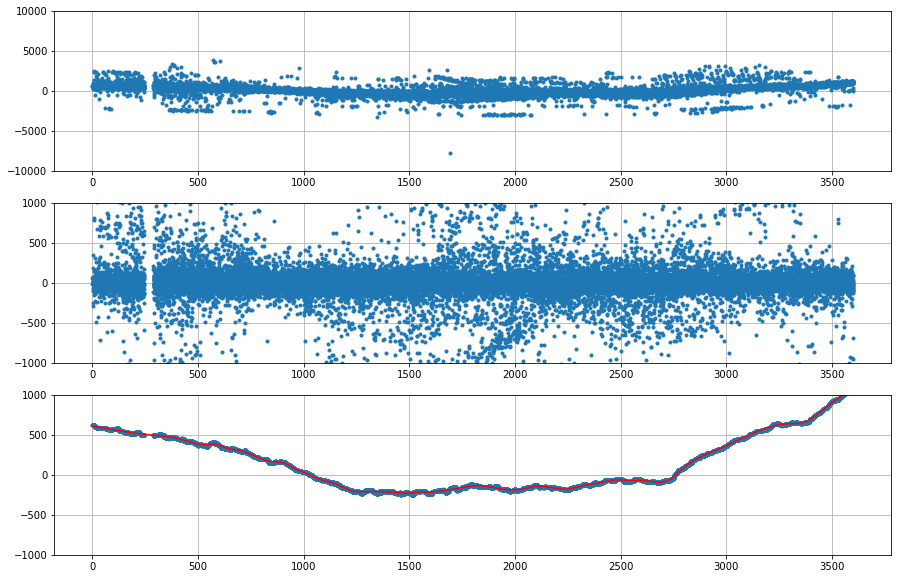

In [12]:
sss.check_result()

In [13]:
sss.save()

In [14]:
###  Decision about station 455
sss.prepare_data(tracks, fst, 455, 20000)
sss.optimize()

Median error: 23.02m using s=2e-12
Max time gap: 121.2s
Delta distance: 1.028m


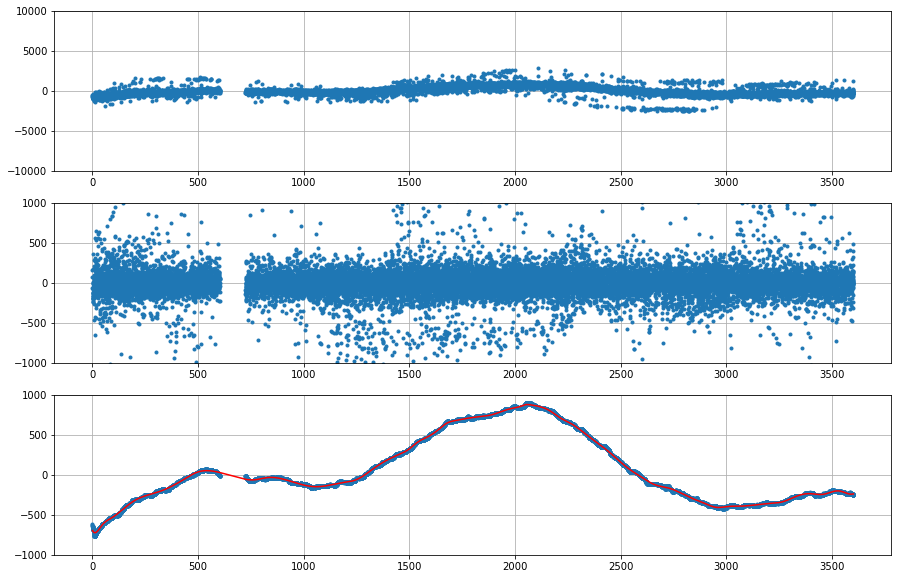

In [15]:
sss.check_result()

In [16]:
sss.save()

In [17]:
## Prepare new stations object

with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

19.770186554524116


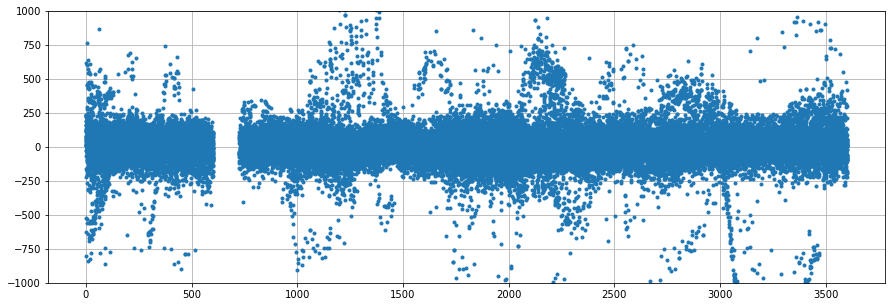

In [18]:
### Check synchronization of stations with time gaps
comb = (216, 455)

_, tel = tracks.aggregate(comb, return_telemetry=True, return_time=True)

st1, st2 = comb
st1_str, st2_str = str(comb[0]), str(comb[1])

t1 = st.correct_time(st1, tel[st1_str].values)
t2 = st.correct_time(st2, tel[st2_str].values)

ind = np.array(list(set(np.where(~np.isnan(t1))[0]).intersection(np.where(~np.isnan(t2))[0])))

output = np.zeros([len(ind), 2])
        
p3 = [P3(lat, lon, hgt) for lat, lon, hgt in zip(tel.latitude.values[ind],
                                                 tel.longitude.values[ind],
                                                 tel.geoAltitude.values[ind])]
        
output[:, 0] = np.array([t - st.time_to(st1, p) for t, p in zip(t1[ind], p3)])
output[:, 1] = np.array([t - st.time_to(st2, p) for t, p in zip(t2[ind], p3)])

print(3e8*np.median(np.fabs(output[:, 0] - output[:, 1])))

figsize(15, 5)
plt.plot(output[:, 0], 1e9*(output[:, 0] - output[:, 1]), '.')
plt.ylim([-1e3, 1e3])
plt.grid()

In [19]:
def another_run(Nsearch=1000, bad=[], future=[], max_err=35, N=20000, n_new_stations=3):
    ## Prepare stations
    with open('stations_params.json', 'r') as f:  
        st_params = json.load(f)

    st = Stations([int(s) for s in st_params])
    st.A0 = A0_B[0]
    st.B = A0_B[1]

    for s in st_params:
        st.update_location(int(s), st_params[s]['location'])

    st.st_params = st_params

    ## Find new stations
    sss = SingleStationSolver()
    sss.find_new_stations(tracks, st, bad+future, N=Nsearch)

    for j in tqdm(sss.new_stations):
    
        if (j in bad) or (j in future):
            continue

        if len(sss.new_stations[j]) < n_new_stations:
            continue

        st.add_station(j)
        sss.prepare_data(tracks, st, j, N)

        if sss.points['t1'].shape[0] < N:
            print(f'Station {j} has less than {N} points, skip')
            continue

        sss.optimize()
        if sss.med_error < max_err and sss.max_dt_gap < 25:
            sss.save('stations_params2.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')

            sss.prepare_data(tracks, st, j, 20000)
            sss.optimize()
            sss.save('stations_params3.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')

            sss.prepare_data(tracks, st, j, 20000)
            sss.optimize()
            sss.save('stations_params4.json')
            print(f'Good station {j}: error={sss.med_error:.4}m, distance={sss.delta_dist:.4}m')
        
        elif sss.med_error < max_err:
            print(f'Station {j}: Large time gap of {sss.max_dt_gap:.4}, error {sss.med_error:.4}m, skip')
        
        else:
            print(f'Bad station: {j}: error={sss.med_error:.4}m')
        
    # Save best result
    with open('stations_params2.json', 'r') as f:  
        st_params2 = json.load(f)

    with open('stations_params3.json', 'r') as f:  
        st_params3 = json.load(f)

    with open('stations_params4.json', 'r') as f:  
        st_params4 = json.load(f)

    for s in st_params2:
        if st_params2[s]['med_error'] <= min(st_params3[s]['med_error'], st_params4[s]['med_error']):
            st_params[s] = st_params2[s]
        elif st_params3[s]['med_error'] <= min(st_params2[s]['med_error'], st_params4[s]['med_error']):
            st_params[s] = st_params3[s]
        else:
            st_params[s] = st_params4[s]

    with open('stations_params.json', 'w') as f:
        json.dump(st_params, f)

    
    print('Number of synchronized stations=', len(st_params))
    return sss

In [21]:
### Multiple runs
future = []
sss = another_run(1000, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/53 [00:00<?, ?it/s]

Good station 184: error=21.03m, distance=22.99m
Good station 184: error=21.07m, distance=1.708m


  4%|▍         | 2/53 [01:28<37:28, 44.09s/it]

Good station 184: error=21.05m, distance=0.896m
Good station 590: error=18.33m, distance=3.308m
Good station 590: error=18.27m, distance=0.9335m


 11%|█▏        | 6/53 [03:18<24:58, 31.88s/it]

Good station 590: error=18.23m, distance=0.6007m
Good station 260: error=19.57m, distance=20.93m
Good station 260: error=19.6m, distance=0.6825m


 13%|█▎        | 7/53 [04:46<33:26, 43.62s/it]

Good station 260: error=19.63m, distance=1.06m
Good station 586: error=20.93m, distance=31.73m
Good station 586: error=21.02m, distance=1.105m


 19%|█▉        | 10/53 [14:54<1:25:04, 118.72s/it]

Good station 586: error=21.02m, distance=2.64m
Good station 297: error=26.01m, distance=18.85m
Good station 297: error=26.08m, distance=0.7493m


 21%|██        | 11/53 [24:20<2:20:42, 201.00s/it]

Good station 297: error=25.83m, distance=1.289m
Good station 366: error=20.3m, distance=14.64m
Good station 366: error=20.35m, distance=1.362m


 25%|██▍       | 13/53 [25:34<1:36:18, 144.47s/it]

Good station 366: error=20.31m, distance=1.399m
Good station 185: error=16.41m, distance=11.85m
Good station 185: error=16.4m, distance=0.2129m


 36%|███▌      | 19/53 [26:55<37:37, 66.40s/it]   

Good station 185: error=16.38m, distance=0.13m
Good station 169: error=21.62m, distance=4.343m
Good station 169: error=21.62m, distance=1.181m


 40%|███▉      | 21/53 [28:24<32:51, 61.62s/it]

Good station 169: error=21.65m, distance=1.247m
Good station 277: error=34.18m, distance=14.73m
Good station 277: error=34.08m, distance=3.872m


100%|██████████| 53/53 [29:52<00:00, 33.82s/it]

Good station 277: error=34.28m, distance=0.8965m
Number of synchronized stations= 61


In [20]:
#future

NameError: name 'future' is not defined

In [146]:
###  Decision about station 455
#st.add_station(277)
#sss.prepare_data(tracks, st, 277, 20000)
#sss.optimize()

Median error: 35.09m using s=2e-12
Max time gap: 3.97s
Delta distance: 2.174m


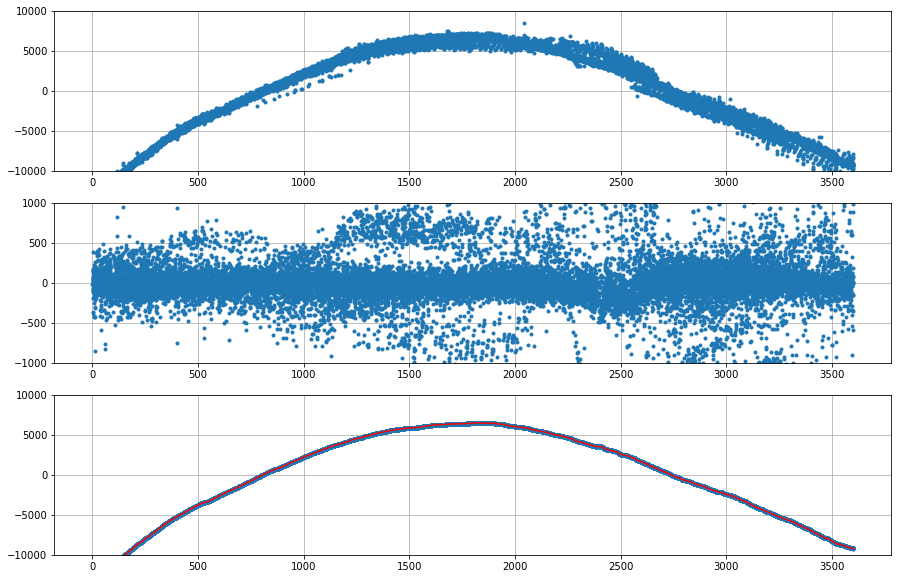

In [147]:
#sss.check_result(ylim3=[-1e4, 1e4])

In [333]:
## Decided to keep station for future
#future = [277]

In [23]:
sss = another_run(1000, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/48 [00:00<?, ?it/s]

Good station 228: error=23.41m, distance=11.54m
Good station 228: error=23.37m, distance=3.134m


  4%|▍         | 2/48 [00:59<22:49, 29.76s/it]

Good station 228: error=23.38m, distance=0.3799m
Good station 607: error=19.7m, distance=22.21m
Good station 607: error=19.66m, distance=1.686m


 10%|█         | 5/48 [02:22<20:13, 28.22s/it]

Good station 607: error=19.66m, distance=1.724m
Good station 231: error=19.6m, distance=7.051m
Good station 231: error=19.58m, distance=1.227m


 15%|█▍        | 7/48 [04:20<27:35, 40.37s/it]

Good station 231: error=19.63m, distance=0.6308m
Good station 595: error=26.67m, distance=18.84m
Good station 595: error=26.74m, distance=2.75m


 25%|██▌       | 12/48 [06:22<18:38, 31.06s/it]

Good station 595: error=26.7m, distance=0.5527m
Good station 677: error=19.69m, distance=15.28m
Good station 677: error=19.74m, distance=0.9094m


 29%|██▉       | 14/48 [08:43<23:11, 40.94s/it]

Good station 677: error=19.7m, distance=1.566m
Good station 491: error=19.4m, distance=9.401m
Good station 491: error=19.41m, distance=0.8627m


100%|██████████| 48/48 [10:08<00:00, 12.67s/it]

Good station 491: error=19.44m, distance=0.9632m
Number of synchronized stations= 67


In [24]:
sss = another_run(1000, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 197: error=21.53m, distance=25.6m
Good station 197: error=21.55m, distance=1.503m


  2%|▏         | 1/42 [01:54<1:18:34, 114.99s/it]

Good station 197: error=21.55m, distance=1.938m
Good station 457: error=20.25m, distance=15.89m
Good station 457: error=20.25m, distance=0.4414m


 19%|█▉        | 8/42 [03:25<12:33, 22.16s/it]   

Good station 457: error=20.23m, distance=0.6044m
Good station 269: error=21.72m, distance=271.2m
Good station 269: error=21.67m, distance=1.019m


 21%|██▏       | 9/42 [04:58<18:21, 33.37s/it]

Good station 269: error=21.68m, distance=0.8882m
Good station 279: error=20.24m, distance=26.13m
Good station 279: error=20.23m, distance=0.1673m


 24%|██▍       | 10/42 [06:07<21:12, 39.78s/it]

Good station 279: error=20.25m, distance=0.1516m


100%|██████████| 42/42 [06:41<00:00,  9.55s/it]

Station 657: Large time gap of 208.4, error 22.21m, skip
Number of synchronized stations= 71


In [27]:
###  Decision about station 455
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])

st.st_params = st_params

st.add_station(657)
sss.prepare_data(tracks, st, 657, 20000)
sss.optimize()

Median error: 22.21m using s=1.2e-11
Max time gap: 208.2s
Delta distance: 17.79m


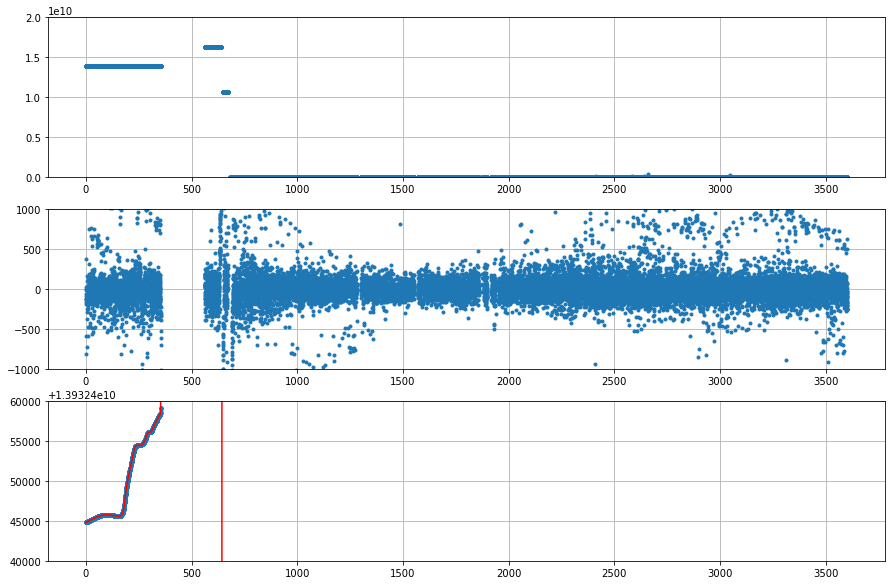

In [28]:
sss.check_result(ylim1=[-1e5, 2e10], ylim3=[1.393244e10, 1.393246e10])

In [ ]:
sss.save()

In [31]:
sss = another_run(800, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/64 [00:00<?, ?it/s]

Good station 627: error=27.49m, distance=66.33m
Good station 627: error=27.5m, distance=1.316m


  6%|▋         | 4/64 [00:55<13:47, 13.80s/it]

Good station 627: error=27.52m, distance=0.8772m
Good station 359: error=22.96m, distance=310.2m
Good station 359: error=22.96m, distance=0.856m


  9%|▉         | 6/64 [02:16<24:03, 24.88s/it]

Good station 359: error=22.84m, distance=0.4403m
Good station 634: error=22.5m, distance=68.31m
Good station 634: error=22.49m, distance=0.9847m


 16%|█▌        | 10/64 [03:12<17:09, 19.07s/it]

Good station 634: error=22.48m, distance=0.7061m
Good station 388: error=25.61m, distance=8.249m
Good station 388: error=25.62m, distance=2.311m


 17%|█▋        | 11/64 [05:02<29:54, 33.85s/it]

Good station 388: error=25.57m, distance=1.545m
Good station 706: error=16.61m, distance=15.61m
Good station 706: error=16.59m, distance=1.262m


 19%|█▉        | 12/64 [06:12<35:12, 40.62s/it]

Good station 706: error=16.57m, distance=1.285m
Good station 490: error=24.62m, distance=13.27m
Good station 490: error=24.67m, distance=0.3199m


 22%|██▏       | 14/64 [07:11<30:36, 36.73s/it]

Good station 490: error=24.7m, distance=0.2583m
Good station 560: error=26.31m, distance=8.738m
Good station 560: error=26.16m, distance=0.8809m


 28%|██▊       | 18/64 [08:28<21:24, 27.93s/it]

Good station 560: error=26.2m, distance=1.292m
Good station 158: error=25.92m, distance=465.5m
Good station 158: error=25.97m, distance=0.6792m


 34%|███▍      | 22/64 [10:02<18:17, 26.13s/it]

Good station 158: error=25.9m, distance=1.585m
Good station 156: error=27.14m, distance=466.9m
Good station 156: error=27.22m, distance=0.9431m


 36%|███▌      | 23/64 [11:22<22:38, 33.13s/it]

Good station 156: error=27.2m, distance=0.9897m
Good station 429: error=22.39m, distance=16.57m
Good station 429: error=22.43m, distance=0.8491m


 38%|███▊      | 24/64 [12:41<26:49, 40.23s/it]

Good station 429: error=22.39m, distance=1.025m
Good station 521: error=20.03m, distance=1.011e+03m
Good station 521: error=19.94m, distance=0.3457m


 39%|███▉      | 25/64 [14:33<34:42, 53.41s/it]

Good station 521: error=19.96m, distance=0.6884m
Good station 131: error=22.95m, distance=4.63m
Good station 131: error=23.02m, distance=1.287m


 41%|████      | 26/64 [15:40<35:34, 56.18s/it]

Good station 131: error=22.72m, distance=2.13m
Good station 358: error=20.89m, distance=36.55m
Good station 358: error=20.8m, distance=0.3484m


 47%|████▋     | 30/64 [16:36<18:55, 33.39s/it]

Good station 358: error=20.8m, distance=0.9558m
Good station 532: error=17.89m, distance=55.2m
Good station 532: error=17.88m, distance=0.5604m


 53%|█████▎    | 34/64 [18:50<16:40, 33.35s/it]

Good station 532: error=17.89m, distance=0.4648m
Good station 626: error=23.22m, distance=45.86m
Good station 626: error=23.22m, distance=1.162m


100%|██████████| 64/64 [23:06<00:00, 21.67s/it]

Good station 626: error=23.22m, distance=0.8138m
Number of synchronized stations= 87


In [353]:
future += [357]

In [32]:
sss = another_run(800, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/54 [00:00<?, ?it/s]

Good station 488: error=25.4m, distance=9.551m
Good station 488: error=25.44m, distance=1.153m


 17%|█▋        | 9/54 [00:50<04:10,  5.57s/it]

Good station 488: error=25.43m, distance=0.0402m
Good station 244: error=24.08m, distance=7.86m
Good station 244: error=24.13m, distance=1.382m


 30%|██▉       | 16/54 [01:55<04:48,  7.59s/it]

Good station 244: error=24.08m, distance=0.9843m


 48%|████▊     | 26/54 [02:19<02:16,  4.86s/it]

Station 679: Large time gap of 54.74, error 20.81m, skip


 57%|█████▋    | 31/54 [02:53<02:04,  5.42s/it]

Bad station: 375: error=38.39m
Good station 157: error=24.1m, distance=438.6m
Good station 157: error=24.07m, distance=0.2045m


 61%|██████    | 33/54 [04:00<03:12,  9.16s/it]

Good station 157: error=23.9m, distance=1.245m
Good station 154: error=23.96m, distance=43.9m
Good station 154: error=24.06m, distance=0.9731m


100%|██████████| 54/54 [05:06<00:00,  5.68s/it]

Good station 154: error=23.97m, distance=1.076m
Number of synchronized stations= 91


In [68]:
###  Decision about station 455
with open('stations_params.json', 'r') as f:  
    st_params = json.load(f)

st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])

st.st_params = st_params

#sss = SingleStationSolver()
#sss.find_new_stations(tracks, st, bad+future, N=800)
st.add_station(679)
sss.prepare_data(tracks, st, 679, 20000)
sss.optimize()

100%|██████████| 2629/2629 [00:01<00:00, 2364.66it/s]


Median error: 20.79m using s=5.5e-12
Max time gap: 54.74s
Delta distance: 16.8m


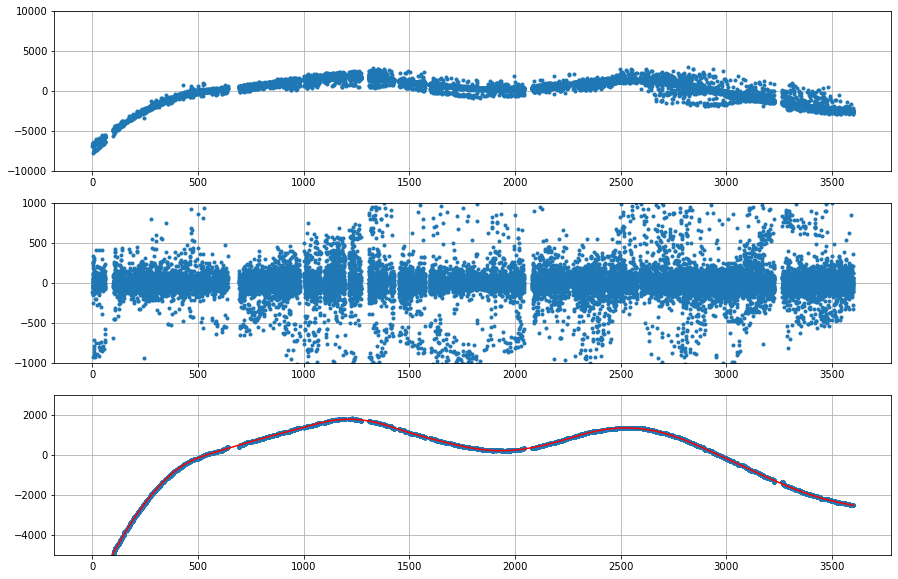

In [69]:
sss.check_result(ylim3=[-5e3, 3e3])

In [86]:
sss.save()
#future += [375]

93

In [87]:
sss = another_run(700, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/55 [00:00<?, ?it/s]

Good station 23: error=23.45m, distance=11.68m
Good station 23: error=23.19m, distance=1.378m


  9%|▉         | 5/55 [01:05<10:58, 13.18s/it]

Good station 23: error=23.4m, distance=1.32m
Good station 173: error=32.1m, distance=30.51m
Good station 173: error=31.98m, distance=4.703m


 18%|█▊        | 10/55 [04:39<22:53, 30.53s/it]

Good station 173: error=31.79m, distance=2.104m
Good station 511: error=27.01m, distance=23.01m
Good station 511: error=26.89m, distance=1.209m


 20%|██        | 11/55 [05:52<26:50, 36.61s/it]

Good station 511: error=26.88m, distance=1.313m
Good station 223: error=32.84m, distance=7.954m
Good station 223: error=32.96m, distance=1.962m


 31%|███       | 17/55 [06:52<13:54, 21.97s/it]

Good station 223: error=33.03m, distance=0.1446m
Good station 166: error=32.63m, distance=14.09m
Good station 166: error=32.52m, distance=0.893m


 35%|███▍      | 19/55 [07:57<14:27, 24.10s/it]

Good station 166: error=32.59m, distance=1.448m
Good station 83: error=33.93m, distance=18.29m
Good station 83: error=33.97m, distance=1.817m


 40%|████      | 22/55 [08:57<12:36, 22.91s/it]

Good station 83: error=34.01m, distance=1.996m
Good station 701: error=21.08m, distance=20.85m
Good station 701: error=21.09m, distance=0.4305m


 45%|████▌     | 25/55 [09:46<10:25, 20.85s/it]

Good station 701: error=20.94m, distance=0.1942m
Good station 326: error=16.51m, distance=3.711m
Good station 326: error=16.52m, distance=1.435m


 51%|█████     | 28/55 [10:48<09:22, 20.85s/it]

Good station 326: error=16.49m, distance=1.518m
Good station 132: error=26.05m, distance=32.85m
Good station 132: error=25.98m, distance=1.921m


 64%|██████▎   | 35/55 [11:40<04:42, 14.10s/it]

Good station 132: error=26.01m, distance=6.811m
Good station 306: error=31.64m, distance=35.02m
Good station 306: error=31.66m, distance=0.303m


 69%|██████▉   | 38/55 [12:27<04:05, 14.45s/it]

Good station 306: error=31.65m, distance=0.06365m
Good station 618: error=22.81m, distance=8.634m
Good station 618: error=22.82m, distance=1.572m


 73%|███████▎  | 40/55 [14:07<05:14, 20.97s/it]

Good station 618: error=22.71m, distance=0.751m
Good station 399: error=21.48m, distance=32.07m
Good station 399: error=21.49m, distance=2.814m


100%|██████████| 55/55 [15:18<00:00, 16.71s/it]

Good station 399: error=21.5m, distance=1.317m
Number of synchronized stations= 105


In [64]:
future += [625, 665]

In [96]:
sss = another_run(700, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/48 [00:00<?, ?it/s]

Good station 170: error=23.01m, distance=17.78m
Good station 170: error=23.01m, distance=0.1681m


 12%|█▎        | 6/48 [00:59<06:56,  9.92s/it]

Good station 170: error=22.98m, distance=0.2585m
Good station 142: error=18.08m, distance=22.34m
Good station 142: error=18.12m, distance=0.435m


 23%|██▎       | 11/48 [02:09<07:29, 12.14s/it]

Good station 142: error=18.13m, distance=0.163m
Good station 386: error=22.52m, distance=9.279m
Good station 386: error=22.58m, distance=1.984m


 73%|███████▎  | 35/48 [02:59<00:54,  4.22s/it]

Good station 386: error=22.54m, distance=0.9312m
Good station 658: error=29.02m, distance=13.18m
Good station 658: error=29.1m, distance=1.458m


100%|██████████| 48/48 [05:10<00:00,  6.46s/it]

Good station 658: error=29.1m, distance=1.864m
Number of synchronized stations= 109


In [97]:
sss = another_run(700, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/48 [00:00<?, ?it/s]

Good station 479: error=20.64m, distance=1.098e+03m
Good station 479: error=20.59m, distance=1.294m


 10%|█         | 5/48 [01:24<12:05, 16.87s/it]

Good station 479: error=20.6m, distance=1.015m
Good station 92: error=31.47m, distance=27.34m
Good station 92: error=31.45m, distance=2.306m


 17%|█▋        | 8/48 [02:24<12:16, 18.40s/it]

Good station 92: error=31.35m, distance=2.057m
Good station 288: error=17.21m, distance=19.48m
Good station 288: error=17.12m, distance=0.8403m


 29%|██▉       | 14/48 [03:31<08:04, 14.24s/it]

Good station 288: error=17.19m, distance=0.6318m
Good station 405: error=28.85m, distance=14.61m
Good station 405: error=28.94m, distance=0.7681m


 40%|███▉      | 19/48 [04:53<07:19, 15.16s/it]

Good station 405: error=28.95m, distance=1.398m
Good station 594: error=19.0m, distance=14.66m
Good station 594: error=19.03m, distance=0.8553m


 60%|██████    | 29/48 [05:57<03:18, 10.45s/it]

Good station 594: error=19.0m, distance=0.7805m
Good station 640: error=20.64m, distance=12.35m
Good station 640: error=20.78m, distance=0.893m


100%|██████████| 48/48 [06:55<00:00,  8.65s/it]

Good station 640: error=20.69m, distance=0.7161m
Number of synchronized stations= 115


In [98]:
sss = another_run(700, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 583: error=28.64m, distance=10.1m
Good station 583: error=28.8m, distance=0.6331m


 17%|█▋        | 7/42 [04:03<20:17, 34.78s/it]

Good station 583: error=28.8m, distance=2.258m
Good station 644: error=33.1m, distance=9.875m
Good station 644: error=33.01m, distance=0.4946m


 26%|██▌       | 11/42 [04:59<13:08, 25.42s/it]

Good station 644: error=33.12m, distance=4.302m
Good station 704: error=21.94m, distance=22.81m
Good station 704: error=21.98m, distance=1.649m


 31%|███       | 13/42 [05:59<12:51, 26.60s/it]

Good station 704: error=21.99m, distance=1.935m
Good station 198: error=27.83m, distance=7.669m
Good station 198: error=27.94m, distance=0.3982m


 48%|████▊     | 20/42 [06:42<05:37, 15.36s/it]

Good station 198: error=27.9m, distance=0.3025m
Good station 709: error=16.87m, distance=9.779m
Good station 709: error=17.0m, distance=0.259m


 69%|██████▉   | 29/42 [10:11<04:10, 19.29s/it]

Good station 709: error=16.95m, distance=1.77m


100%|██████████| 42/42 [10:33<00:00, 15.10s/it]

Station 596: Large time gap of 279.4, error 18.38m, skip
Number of synchronized stations= 120


In [101]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(596)
sss.prepare_data(tracks, st, 596, 20000)
sss.optimize()

Number of synchronized stations= 120


Median error: 18.36m using s=3e-12
Max time gap: 279.3s
Delta distance: 7.799m


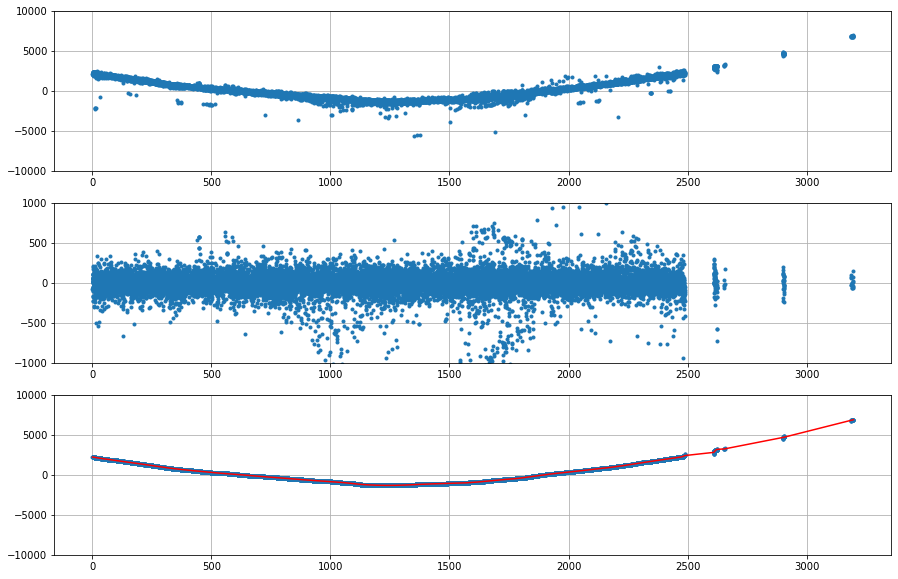

In [102]:
sss.check_result(ylim3=[-1e4, 1e4])

In [104]:
sss.save()

[[2487.3497663626854, 3600]]

In [106]:
sss = another_run(600, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/45 [00:00<?, ?it/s]

Good station 529: error=31.33m, distance=30.32m
Good station 529: error=31.41m, distance=2.72m


 13%|█▎        | 6/45 [00:54<05:55,  9.13s/it]

Good station 529: error=31.52m, distance=2.126m
Good station 507: error=29.37m, distance=23.46m
Good station 507: error=29.31m, distance=2.344m


 16%|█▌        | 7/45 [01:50<11:26, 18.07s/it]

Good station 507: error=29.34m, distance=0.6471m


 18%|█▊        | 8/45 [02:07<10:59, 17.83s/it]

Station 512: Large time gap of 66.06, error 27.01m, skip
Good station 611: error=24.65m, distance=7.918m
Good station 611: error=24.37m, distance=1.606m


 20%|██        | 9/45 [03:10<17:06, 28.51s/it]

Good station 611: error=24.88m, distance=0.5657m


 24%|██▍       | 11/45 [03:31<12:01, 21.23s/it]

Bad station: 520: error=44.67m
Good station 196: error=22.79m, distance=1.871e+03m
Good station 196: error=22.82m, distance=0.4447m


 29%|██▉       | 13/45 [05:05<16:18, 30.58s/it]

Good station 196: error=22.84m, distance=2.003m


 36%|███▌      | 16/45 [05:33<10:16, 21.28s/it]

Bad station: 669: error=47.78m
Good station 193: error=23.86m, distance=5.282m
Good station 193: error=23.95m, distance=0.4429m


 38%|███▊      | 17/45 [06:13<11:29, 24.63s/it]

Good station 193: error=23.89m, distance=1.851m
Good station 411: error=27.21m, distance=24.71m
Good station 411: error=27.11m, distance=0.3496m


 42%|████▏     | 19/45 [07:16<11:39, 26.91s/it]

Good station 411: error=27.11m, distance=1.334m
Good station 687: error=27.52m, distance=88.08m
Good station 687: error=27.5m, distance=0.199m


 60%|██████    | 27/45 [08:18<04:18, 14.34s/it]

Good station 687: error=27.8m, distance=3.092m
Good station 664: error=21.7m, distance=20.77m
Good station 664: error=21.77m, distance=2.878m


 67%|██████▋   | 30/45 [09:27<04:09, 16.63s/it]

Good station 664: error=21.79m, distance=2.046m
Good station 518: error=20.75m, distance=27.38m
Good station 518: error=20.75m, distance=0.28m


 73%|███████▎  | 33/45 [10:28<03:31, 17.60s/it]

Good station 518: error=20.62m, distance=0.8257m
Good station 463: error=21.49m, distance=28.95m
Good station 463: error=21.6m, distance=0.726m


100%|██████████| 45/45 [11:34<00:00, 15.43s/it]

Good station 463: error=21.56m, distance=1.59m
Number of synchronized stations= 131


In [107]:
future += [520, 669] #[520, 669, 132]

In [114]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(512)
sss.prepare_data(tracks, st, 512, 20000)
sss.optimize()

Number of synchronized stations= 131


Median error: 27.06m using s=2.5e-12
Max time gap: 65.87s
Delta distance: 3.298m


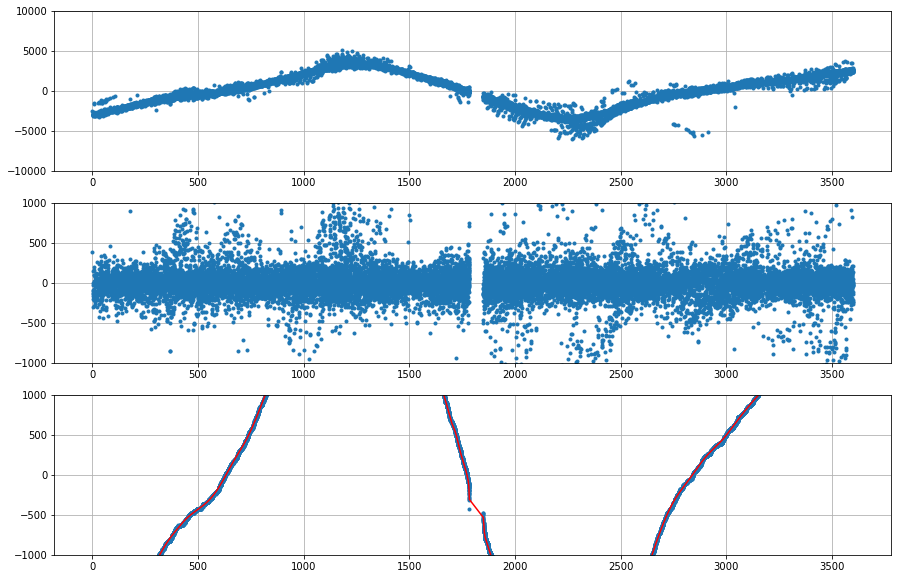

In [115]:
sss.check_result()

In [116]:
sss.save()

In [385]:
from src.solvers import SingleStationSolver

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(478)
sss.prepare_data(tracks, st, 478, 20000)
sss.optimize()

Number of synchronized stations= 126


Median error: 29.78m using s=2.5e-12
Max time gap: 134.0s
Delta distance: 34.14m


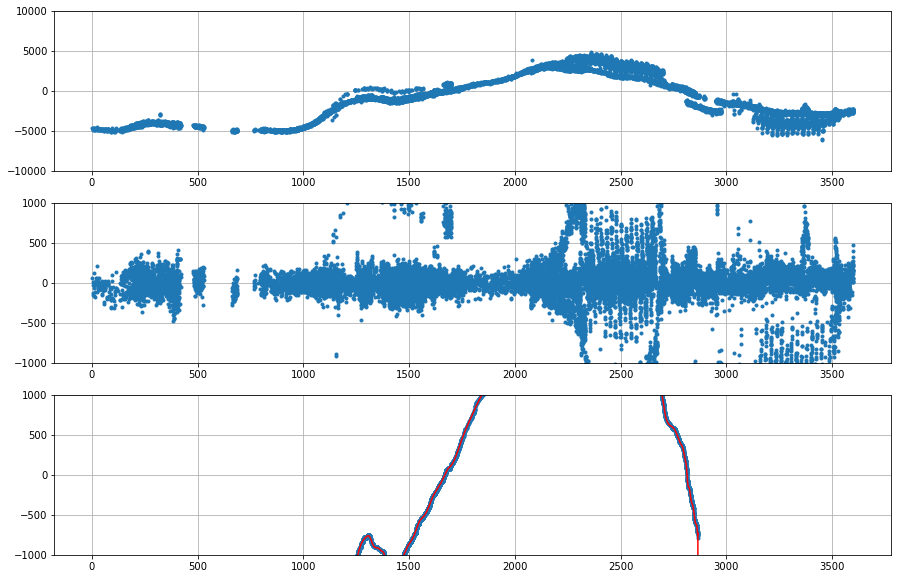

In [386]:
sss.check_result()

In [387]:
future += [478]

In [117]:
sss = another_run(600, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/32 [00:00<?, ?it/s]

Good station 527: error=31.93m, distance=35.29m
Good station 527: error=31.82m, distance=0.6322m


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]

Good station 527: error=31.79m, distance=2.137m
Number of synchronized stations= 133


In [123]:
sss = another_run(500, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 10%|▉         | 4/42 [00:20<03:18,  5.22s/it]

Bad station: 256: error=40.23m
Good station 203: error=30.35m, distance=16.45m
Good station 203: error=30.17m, distance=0.6082m


 14%|█▍        | 6/42 [01:27<10:06, 16.84s/it]

Good station 203: error=30.32m, distance=1.299m
Good station 674: error=22.62m, distance=1.109e+04m
Good station 674: error=22.59m, distance=2.728m


 17%|█▋        | 7/42 [02:51<18:51, 32.33s/it]

Good station 674: error=22.57m, distance=2.152m
Good station 315: error=25.2m, distance=15.57m
Good station 315: error=25.27m, distance=0.8434m


 19%|█▉        | 8/42 [04:19<26:08, 46.14s/it]

Good station 315: error=25.34m, distance=1.286m
Good station 155: error=21.22m, distance=15.52m
Good station 155: error=21.23m, distance=0.941m


 36%|███▌      | 15/42 [05:13<08:25, 18.73s/it]

Good station 155: error=21.31m, distance=0.513m
Good station 620: error=28.66m, distance=13.96m
Good station 620: error=28.61m, distance=3.931m


 40%|████      | 17/42 [06:05<08:29, 20.40s/it]

Good station 620: error=28.66m, distance=2.875m
Good station 350: error=27.44m, distance=4.542m
Good station 350: error=27.4m, distance=0.2319m


 43%|████▎     | 18/42 [06:49<09:29, 23.75s/it]

Good station 350: error=27.39m, distance=0.1532m


 55%|█████▍    | 23/42 [07:07<04:20, 13.72s/it]

Bad station: 162: error=36.25m
Good station 240: error=15.99m, distance=19.12m
Good station 240: error=16.05m, distance=0.2509m


 67%|██████▋   | 28/42 [08:16<03:12, 13.73s/it]

Good station 240: error=16.01m, distance=0.8053m
Good station 372: error=25.25m, distance=46.18m
Good station 372: error=25.19m, distance=0.2543m


 79%|███████▊  | 33/42 [09:12<01:54, 12.76s/it]

Good station 372: error=25.22m, distance=0.398m
Good station 369: error=23.75m, distance=13.98m
Good station 369: error=23.91m, distance=0.6762m


 83%|████████▎ | 35/42 [10:14<01:51, 15.99s/it]

Good station 369: error=23.87m, distance=1.176m


100%|██████████| 42/42 [10:40<00:00, 15.25s/it]

Bad station: 689: error=43.66m
Number of synchronized stations= 142


In [124]:
future += [256, 162, 689]

In [125]:
sss = another_run(500, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/32 [00:00<?, ?it/s]

Good station 542: error=27.0m, distance=14.13m
Good station 542: error=27.03m, distance=1.091m


 12%|█▎        | 4/32 [00:51<06:03, 12.98s/it]

Good station 542: error=27.04m, distance=0.8506m
Good station 659: error=28.17m, distance=4.466m
Good station 659: error=28.07m, distance=1.565m


100%|██████████| 32/32 [51:45<00:00, 97.05s/it]  

Good station 659: error=28.45m, distance=1.992m
Number of synchronized stations= 144


In [126]:
sss = another_run(500, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 33%|███▎      | 10/30 [00:22<00:44,  2.21s/it]

Bad station: 599: error=37.79m
Good station 522: error=24.47m, distance=9.718m
Good station 522: error=24.43m, distance=0.2362m


100%|██████████| 30/30 [01:18<00:00,  2.63s/it]

Good station 522: error=24.43m, distance=0.7203m
Number of synchronized stations= 145


In [127]:
future += [599]

In [128]:
sss = another_run(500, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

100%|██████████| 28/28 [00:00<00:00, 400820.86it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'stations_params2.json'

In [406]:
from src.solvers import SingleStationSolver

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(518)
sss.prepare_data(tracks, st, 518, 20000)
sss.optimize()

Number of synchronized stations= 142


Median error: 19.33m using s=2e-12
Max time gap: 29.14s
Delta distance: 26.29m


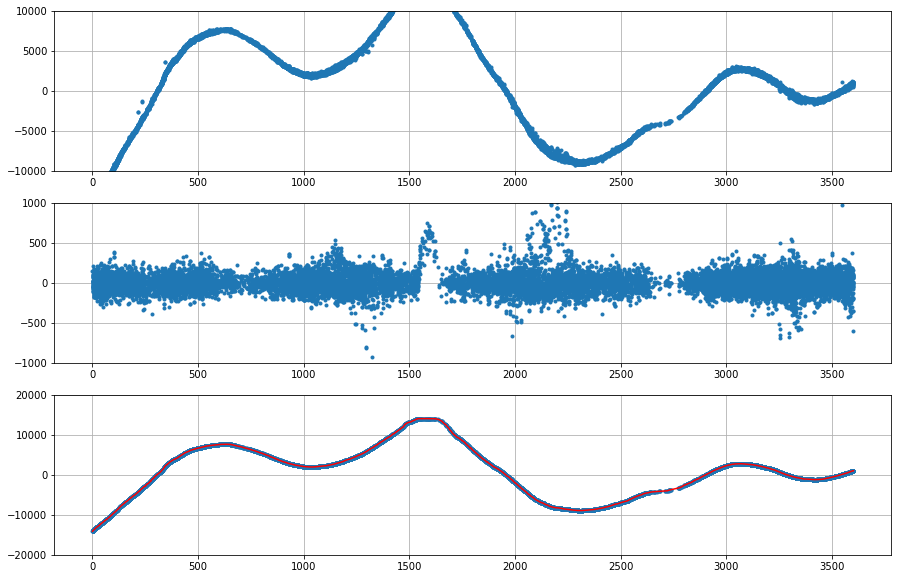

In [409]:
sss.check_result(ylim3=[-2e4, 2e4])

In [410]:
sss.save()

In [129]:
sss = another_run(400, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/42 [00:00<?, ?it/s]

Good station 26: error=31.94m, distance=1.707e+05m
Good station 26: error=32.03m, distance=2.043m


 14%|█▍        | 6/42 [02:08<12:53, 21.48s/it]

Good station 26: error=31.93m, distance=0.4935m


 17%|█▋        | 7/42 [02:34<12:59, 22.28s/it]

Bad station: 55: error=37.38m


 29%|██▊       | 12/42 [02:59<06:08, 12.27s/it]

Bad station: 290: error=47.11m
Good station 558: error=31.03m, distance=34.02m
Good station 558: error=31.01m, distance=1.027m


 31%|███       | 13/42 [04:42<12:07, 25.09s/it]

Good station 558: error=30.95m, distance=1.755m
Good station 495: error=20.6m, distance=68.66m
Good station 495: error=20.68m, distance=2.048m


 36%|███▌      | 15/42 [05:36<11:34, 25.73s/it]

Good station 495: error=20.78m, distance=1.12m
Good station 610: error=26.69m, distance=88.61m
Good station 610: error=26.83m, distance=1.256m


 45%|████▌     | 19/42 [06:40<08:10, 21.31s/it]

Good station 610: error=26.82m, distance=1.119m
Good station 175: error=32.26m, distance=59.58m
Good station 175: error=32.17m, distance=0.03204m


 48%|████▊     | 20/42 [07:27<09:06, 24.83s/it]

Good station 175: error=32.22m, distance=4.398m
Good station 307: error=28.83m, distance=11.34m
Good station 307: error=28.88m, distance=3.082m


 62%|██████▏   | 26/42 [08:33<04:37, 17.31s/it]

Good station 307: error=28.77m, distance=1.88m
Good station 321: error=34.34m, distance=49.61m
Good station 321: error=34.37m, distance=1.605m


 67%|██████▋   | 28/42 [09:25<04:27, 19.10s/it]

Good station 321: error=34.29m, distance=0.4151m
Good station 304: error=33.21m, distance=11.6m
Good station 304: error=33.3m, distance=0.8106m


 69%|██████▉   | 29/42 [11:02<06:18, 29.14s/it]

Good station 304: error=33.29m, distance=2.902m
Good station 218: error=18.88m, distance=9.192m
Good station 218: error=18.94m, distance=1.522m


 76%|███████▌  | 32/42 [12:00<04:16, 25.69s/it]

Good station 218: error=18.89m, distance=0.6805m
Good station 114: error=22.2m, distance=19.93m
Good station 114: error=22.21m, distance=1.893m


 79%|███████▊  | 33/42 [12:47<04:19, 28.79s/it]

Good station 114: error=22.18m, distance=1.849m


100%|██████████| 42/42 [12:49<00:00, 18.31s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 155


In [130]:
#bad += [377, 577]
future += [55, 290]#, 346]

In [131]:
sss = another_run(400, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/39 [00:00<?, ?it/s]

Good station 201: error=24.72m, distance=17.29m
Good station 201: error=24.75m, distance=0.8166m


 13%|█▎        | 5/39 [00:39<04:27,  7.88s/it]

Good station 201: error=24.75m, distance=0.1407m
Good station 352: error=33.45m, distance=28.19m
Good station 352: error=33.37m, distance=0.9131m


 15%|█▌        | 6/39 [01:29<09:27, 17.19s/it]

Good station 352: error=33.39m, distance=1.915m
Good station 616: error=24.65m, distance=86.16m
Good station 616: error=24.62m, distance=0.5485m


 28%|██▊       | 11/39 [02:50<07:45, 16.64s/it]

Good station 616: error=24.62m, distance=1.963m


 79%|███████▉  | 31/39 [02:51<00:29,  3.74s/it]

Station 368 has less than 20000 points, skip


100%|██████████| 39/39 [02:53<00:00,  4.45s/it]

Station 673 has less than 20000 points, skip
Number of synchronized stations= 158


In [132]:
sss = another_run(400, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/39 [00:00<?, ?it/s]

Good station 469: error=33.67m, distance=5.663m
Good station 469: error=33.4m, distance=1.148m


 15%|█▌        | 6/39 [00:49<04:32,  8.26s/it]

Good station 469: error=33.58m, distance=1.694m
Good station 543: error=31.68m, distance=9.945m
Good station 543: error=31.64m, distance=0.0497m


 18%|█▊        | 7/39 [01:32<07:56, 14.88s/it]

Good station 543: error=31.82m, distance=0.02189m


 21%|██        | 8/39 [01:50<08:06, 15.70s/it]

Bad station: 367: error=39.95m
Good station 215: error=22.94m, distance=317.4m
Good station 215: error=22.92m, distance=0.5544m


 23%|██▎       | 9/39 [03:01<14:15, 28.53s/it]

Good station 215: error=22.97m, distance=5.814m


 28%|██▊       | 11/39 [03:21<09:53, 21.21s/it]

Bad station: 694: error=35.1m


 36%|███▌      | 14/39 [03:44<06:13, 14.94s/it]

Bad station: 673: error=40.93m


100%|██████████| 39/39 [03:45<00:00,  5.79s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 161


In [133]:
future += [367, 694, 673]#, 265]

In [134]:
sss = another_run(400, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/33 [00:00<?, ?it/s]

Good station 236: error=28.52m, distance=13.99m
Good station 236: error=28.74m, distance=1.849m


 15%|█▌        | 5/33 [00:57<05:19, 11.42s/it]

Good station 236: error=28.54m, distance=1.237m


 18%|█▊        | 6/33 [01:20<06:20, 14.08s/it]

Station 667: Large time gap of 50.02, error 20.03m, skip
Good station 176: error=28.0m, distance=53.71m
Good station 176: error=28.07m, distance=0.5101m


 27%|██▋       | 9/33 [02:25<07:05, 17.73s/it]

Good station 176: error=28.16m, distance=2.652m
Good station 624: error=26.74m, distance=784.8m
Good station 624: error=26.77m, distance=2.15m


 48%|████▊     | 16/33 [03:37<03:43, 13.16s/it]

Good station 624: error=26.77m, distance=1.116m


 79%|███████▉  | 26/33 [03:39<00:41,  5.90s/it]

Station 502 has less than 20000 points, skip


100%|██████████| 33/33 [03:40<00:00,  6.67s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 164


In [10]:
bad += [641]

In [139]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(667)
sss.prepare_data(tracks, st, 667, 20000)
sss.optimize()

Number of synchronized stations= 164


Median error: 20.05m using s=3e-12
Max time gap: 50.02s
Delta distance: 43.29m


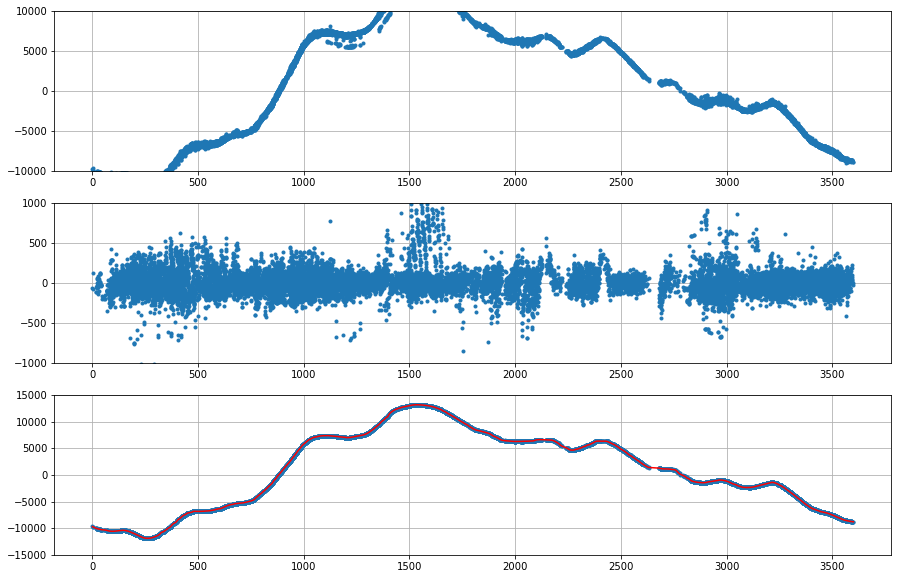

In [140]:
sss.check_result(ylim3=[-1.5e4, 1.5e4])

In [141]:
sss.save()

In [142]:
sss = another_run(400, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/29 [00:00<?, ?it/s]

Good station 502: error=27.38m, distance=68.33m
Good station 502: error=27.33m, distance=0.2574m


 17%|█▋        | 5/29 [01:01<04:55, 12.30s/it]

Good station 502: error=27.36m, distance=1.321m


100%|██████████| 29/29 [01:02<00:00,  2.16s/it]

Station 368 has less than 20000 points, skip
Number of synchronized stations= 166


In [148]:
sss = another_run(300, bad, future, max_err=35, N=20000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/41 [00:00<?, ?it/s]

Good station 578: error=33.34m, distance=62.78m
Good station 578: error=33.43m, distance=1.471m


 15%|█▍        | 6/41 [01:21<07:54, 13.56s/it]

Good station 578: error=33.07m, distance=2.192m
Good station 379: error=33.72m, distance=8.9m
Good station 379: error=33.78m, distance=1.256m


 17%|█▋        | 7/41 [05:37<34:05, 60.18s/it]

Good station 379: error=33.87m, distance=0.6044m
Good station 498: error=24.45m, distance=1.252e+04m
Good station 498: error=24.43m, distance=0.5523m


 20%|█▉        | 8/41 [06:46<34:11, 62.15s/it]

Good station 498: error=24.39m, distance=1.494m


 22%|██▏       | 9/41 [06:48<25:34, 47.94s/it]

Station 570 has less than 20000 points, skip


 29%|██▉       | 12/41 [06:49<11:39, 24.12s/it]

Station 445 has less than 20000 points, skip


 32%|███▏      | 13/41 [07:28<12:31, 26.84s/it]

Station 681: Large time gap of 182.9, error 27.61m, skip
Good station 192: error=20.51m, distance=21.73m
Good station 192: error=20.51m, distance=0.4663m


 34%|███▍      | 14/41 [08:42<16:42, 37.13s/it]

Good station 192: error=20.53m, distance=0.3502m
Good station 444: error=24.09m, distance=18.18m
Good station 444: error=24.23m, distance=0.3094m


 39%|███▉      | 16/41 [10:02<15:57, 38.29s/it]

Good station 444: error=24.17m, distance=0.6641m
Good station 614: error=24.08m, distance=15.16m
Good station 614: error=24.08m, distance=2.974m


 41%|████▏     | 17/41 [11:03<17:15, 43.16s/it]

Good station 614: error=24.13m, distance=0.007899m
Good station 584: error=22.42m, distance=8.717m
Good station 584: error=22.39m, distance=1.103m


 44%|████▍     | 18/41 [12:24<19:54, 51.91s/it]

Good station 584: error=22.38m, distance=0.2071m
Good station 360: error=32.05m, distance=30.02m
Good station 360: error=32.1m, distance=1.33m


 46%|████▋     | 19/41 [13:08<18:16, 49.84s/it]

Good station 360: error=32.0m, distance=0.7223m


 56%|█████▌    | 23/41 [13:25<06:54, 23.01s/it]

Station 368: Large time gap of 367.4, error 22.88m, skip


 73%|███████▎  | 30/41 [13:25<01:42,  9.36s/it]

Station 165 has less than 20000 points, skip


100%|██████████| 41/41 [13:40<00:00, 20.02s/it]

Station 675: Large time gap of 64.64, error 24.28m, skip
Number of synchronized stations= 174


In [11]:
bad += [312, 702]
future += [635]

In [157]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(681)
sss.prepare_data(tracks, st, 681, 20000)
sss.optimize()

Number of synchronized stations= 174


Median error: 27.72m using s=6.5e-12
Max time gap: 182.9s
Delta distance: 12.02m


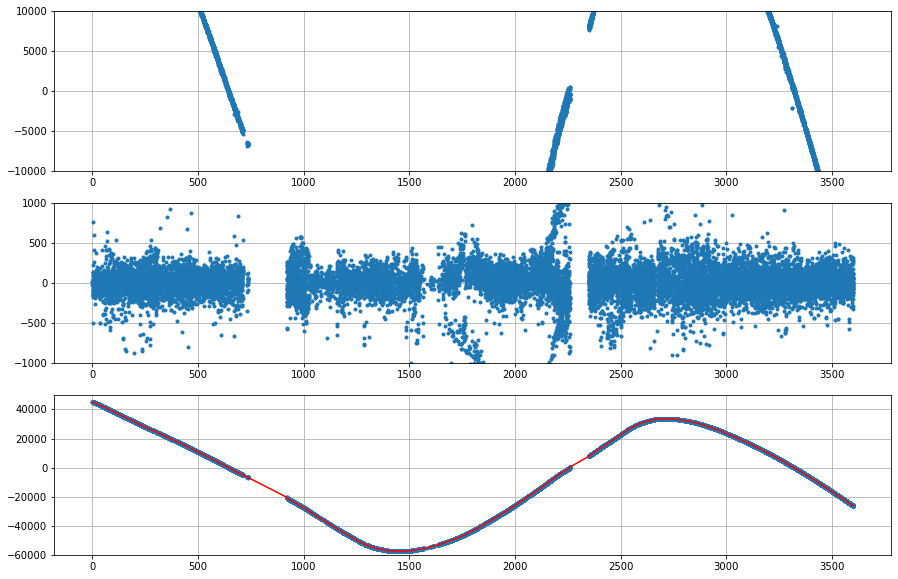

In [158]:
sss.check_result(ylim3=[-6e4, 5e4])

In [159]:
sss.save()

In [160]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(368)
sss.prepare_data(tracks, st, 368, 20000)
sss.optimize()

Number of synchronized stations= 175


Median error: 22.94m using s=5e-12
Max time gap: 367.4s
Delta distance: 2.418m


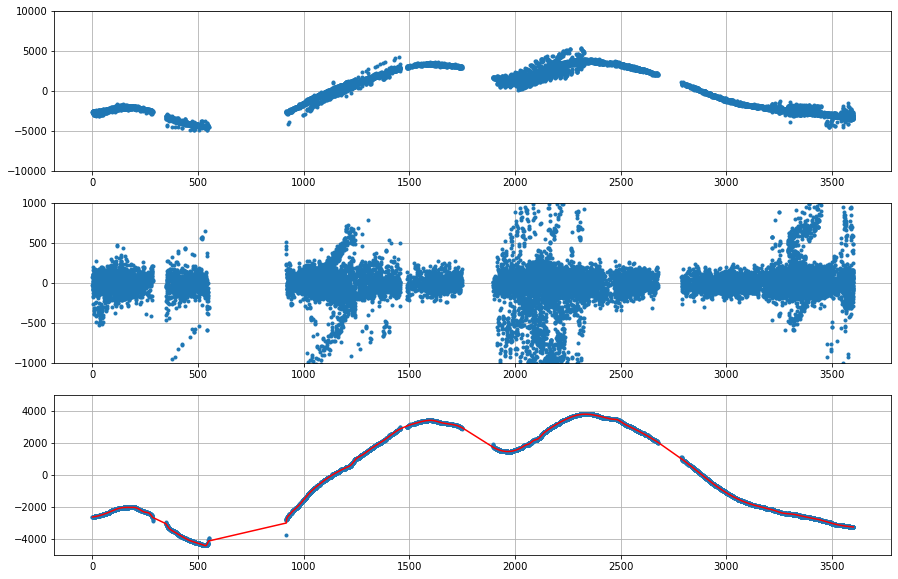

In [161]:
sss.check_result(ylim3=[-5e3, 5e3])

In [162]:
future += [368]

In [165]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(675)
sss.prepare_data(tracks, st, 675, 20000)
sss.optimize()

Number of synchronized stations= 175


Median error: 24.29m using s=7e-12
Max time gap: 64.64s
Delta distance: 16.55m


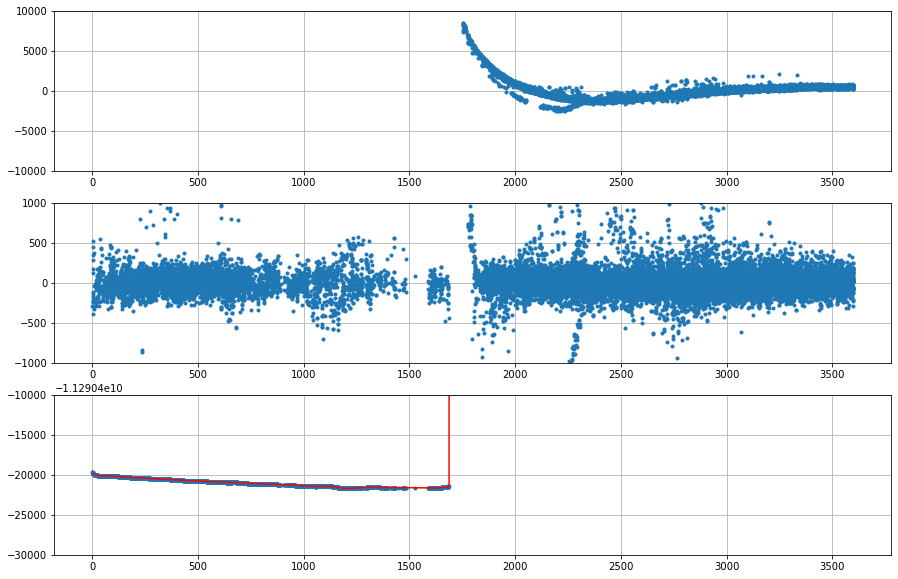

In [166]:
sss.check_result(ylim3=[-1.129043e10, -1.129041e10])

In [167]:
sss.save()

In [168]:
sss = another_run(300, bad, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 20%|██        | 6/30 [00:14<00:56,  2.36s/it]

Bad station: 570: error=41.62m
Good station 445: error=30.36m, distance=2.117e+03m
Good station 445: error=30.41m, distance=1.386m


 30%|███       | 9/30 [01:01<02:46,  7.94s/it]

Good station 445: error=30.4m, distance=0.05765m


100%|██████████| 30/30 [01:01<00:00,  2.07s/it]

Station 165 has less than 15000 points, skip
Number of synchronized stations= 177


In [169]:
future += [570]

In [476]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(439)
sss.prepare_data(tracks, st, 439, 20000)
sss.optimize()

Number of synchronized stations= 175


Median error: 23.56m using s=2.5e-12
Max time gap: 262.5s
Delta distance: 31.89m


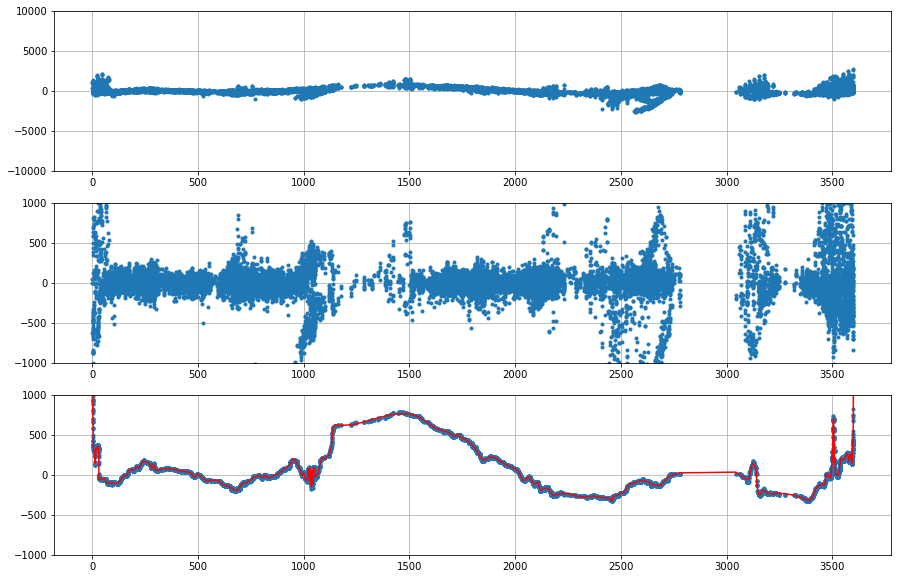

In [477]:
sss.check_result()

In [478]:
future += [439]

In [170]:
sss = another_run(200, bad, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/36 [00:00<?, ?it/s]

Good station 576: error=25.64m, distance=23.79m
Good station 576: error=25.62m, distance=1.684m


 19%|█▉        | 7/36 [01:46<07:22, 15.26s/it]

Good station 576: error=25.57m, distance=0.5129m


 28%|██▊       | 10/36 [01:47<04:09,  9.60s/it]

Station 597 has less than 15000 points, skip


 31%|███       | 11/36 [01:58<04:02,  9.70s/it]

Station 441: Large time gap of 76.5, error 23.99m, skip


 33%|███▎      | 12/36 [02:13<04:15, 10.66s/it]

Bad station: 442: error=38.14m


 36%|███▌      | 13/36 [02:14<03:20,  8.70s/it]

Station 698 has less than 15000 points, skip
Good station 489: error=27.31m, distance=0.2762m
Good station 489: error=27.12m, distance=1.361m


 47%|████▋     | 17/36 [03:15<03:53, 12.28s/it]

Good station 489: error=27.18m, distance=1.554m
Good station 492: error=29.61m, distance=94.25m
Good station 492: error=29.27m, distance=0.56m


 50%|█████     | 18/36 [05:25<09:22, 31.28s/it]

Good station 492: error=29.34m, distance=1.133m
Good station 696: error=28.35m, distance=7.54m
Good station 696: error=28.44m, distance=0.9653m


 58%|█████▊    | 21/36 [06:07<06:02, 24.17s/it]

Good station 696: error=28.45m, distance=1.519m


 69%|██████▉   | 25/36 [06:07<02:30, 13.65s/it]

Station 711 has less than 15000 points, skip


 78%|███████▊  | 28/36 [06:08<01:14,  9.35s/it]

Station 165 has less than 15000 points, skip


 83%|████████▎ | 30/36 [06:18<00:50,  8.34s/it]

Station 253: Large time gap of 59.13, error 32.47m, skip


100%|██████████| 36/36 [06:19<00:00, 10.53s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 181


In [171]:
#bad += [214]
future += [442]

In [172]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(441)
sss.prepare_data(tracks, st, 441, 20000)
sss.optimize()

Number of synchronized stations= 181


Median error: 23.9m using s=2e-12
Max time gap: 77.52s
Delta distance: 6.645m


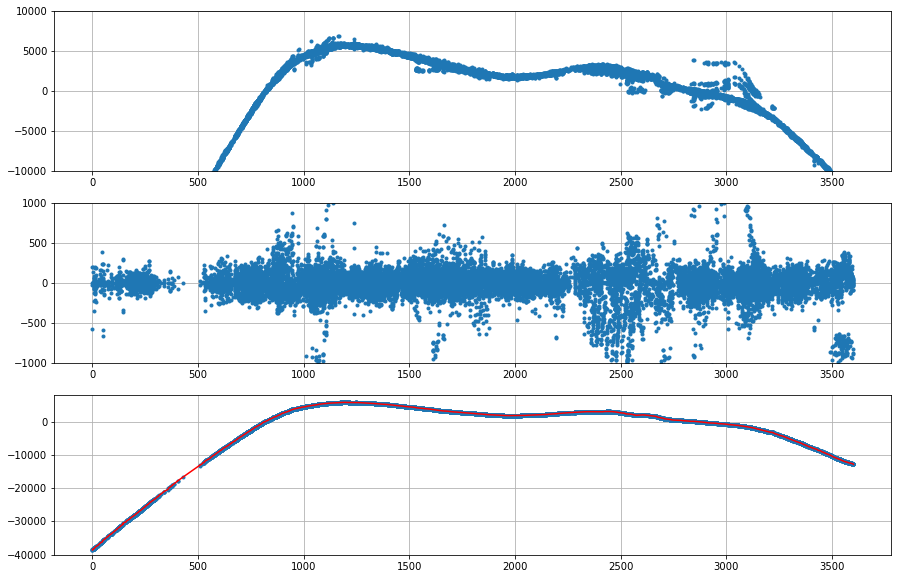

In [173]:
sss.check_result(ylim3=[-4e4, 8e3])

In [174]:
sss.save()

In [175]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(253)
sss.prepare_data(tracks, st, 253, 20000)
sss.optimize()

Number of synchronized stations= 182


Median error: 32.41m using s=5.5e-12
Max time gap: 59.13s
Delta distance: 10.67m


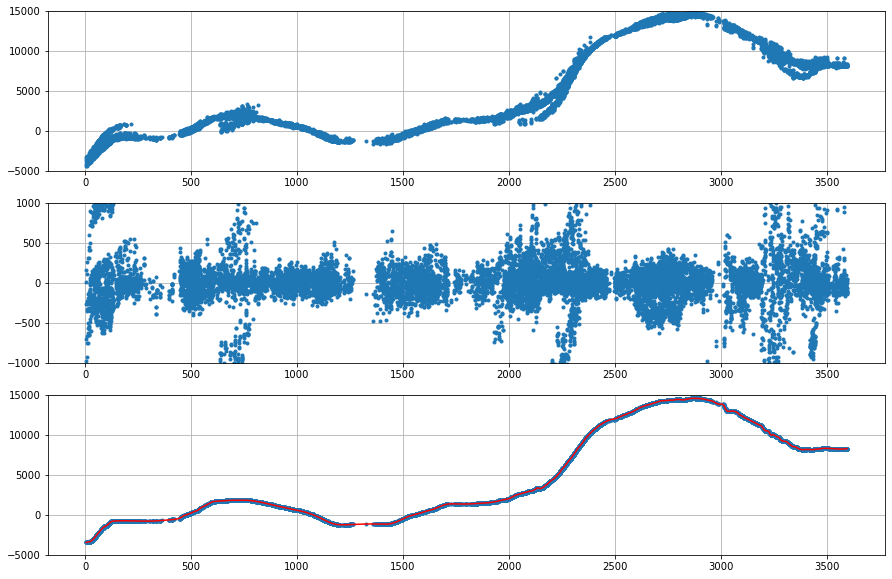

In [176]:
sss.check_result(ylim1=[-5e3, 1.5e4], ylim3=[-5e3, 1.5e4])

In [177]:
sss.save()

In [178]:
sss = another_run(200, bad, [], max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

 15%|█▌        | 7/46 [01:44<09:43, 14.95s/it]

Bad station: 625: error=39.11m


 17%|█▋        | 8/46 [02:05<10:06, 15.96s/it]

Bad station: 520: error=36.34m
Good station 55: error=24.07m, distance=22.04m
Good station 55: error=23.83m, distance=0.3103m


 20%|█▉        | 9/46 [04:32<25:36, 41.54s/it]

Good station 55: error=24.22m, distance=0.7094m
Good station 694: error=32.05m, distance=77.22m
Good station 694: error=32.01m, distance=2.567m


 22%|██▏       | 10/46 [06:03<31:17, 52.17s/it]

Good station 694: error=31.91m, distance=1.197m


 24%|██▍       | 11/46 [06:22<25:53, 44.39s/it]

Bad station: 673: error=41.5m


 26%|██▌       | 12/46 [06:41<21:31, 37.98s/it]

Bad station: 367: error=42.63m
Good station 256: error=32.11m, distance=13.57m
Good station 256: error=31.99m, distance=1.83m


 28%|██▊       | 13/46 [08:35<31:55, 58.04s/it]

Good station 256: error=32.01m, distance=0.9256m
Good station 599: error=30.85m, distance=18.15m
Good station 599: error=30.77m, distance=0.5279m


 30%|███       | 14/46 [09:43<32:27, 60.85s/it]

Good station 599: error=30.73m, distance=1.024m


 33%|███▎      | 15/46 [10:08<26:15, 50.82s/it]

Bad station: 290: error=39.97m


 35%|███▍      | 16/46 [10:26<20:37, 41.25s/it]

Bad station: 570: error=37.25m
Good station 665: error=33.82m, distance=28.59m
Good station 665: error=33.21m, distance=7.131m


 39%|███▉      | 18/46 [12:54<26:10, 56.09s/it]

Good station 665: error=33.62m, distance=2.46m


 41%|████▏     | 19/46 [13:30<23:05, 51.31s/it]

Bad station: 669: error=45.01m


 43%|████▎     | 20/46 [14:03<20:11, 46.59s/it]

Bad station: 375: error=39.37m


 48%|████▊     | 22/46 [14:04<10:48, 27.04s/it]

Station 597 has less than 15000 points, skip


 50%|█████     | 23/46 [14:29<10:08, 26.45s/it]

Bad station: 442: error=38.33m


 52%|█████▏    | 24/46 [14:51<09:18, 25.41s/it]

Bad station: 162: error=37.83m


 54%|█████▍    | 25/46 [14:52<06:39, 19.01s/it]

Station 698 has less than 15000 points, skip


 63%|██████▎   | 29/46 [15:13<03:02, 10.73s/it]

Bad station: 689: error=36.7m


 70%|██████▉   | 32/46 [15:27<01:55,  8.27s/it]

Station 368: Large time gap of 367.4, error 23.19m, skip


 78%|███████▊  | 36/46 [15:27<00:47,  4.79s/it]

Station 711 has less than 15000 points, skip


 85%|████████▍ | 39/46 [15:28<00:23,  3.36s/it]

Station 165 has less than 15000 points, skip


100%|██████████| 46/46 [15:28<00:00, 20.19s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 188


In [179]:
#bad += [635]
#future = [357, 625, 520, 673, 367, 290, 346, 570, 669, 375, 442, 162, 265, 689]
future += [625, 520, 673, 367, 290, 570, 669, 375, 442, 162, 689]

In [183]:
sss = another_run(200, bad, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/27 [00:00<?, ?it/s]

Good station 628: error=34.53m, distance=14.54m
Good station 628: error=34.31m, distance=2.08m


  4%|▎         | 1/27 [00:55<24:09, 55.74s/it]

Good station 628: error=34.44m, distance=1.661m
Good station 194: error=21.3m, distance=27.95m
Good station 194: error=21.15m, distance=0.6618m


  7%|▋         | 2/27 [01:47<22:22, 53.69s/it]

Good station 194: error=21.18m, distance=0.1396m


 19%|█▊        | 5/27 [14:38<1:13:01, 199.14s/it]

Bad station: 591: error=42.11m


 22%|██▏       | 6/27 [14:54<53:23, 152.57s/it]  

Bad station: 535: error=45.03m


 26%|██▌       | 7/27 [14:55<37:23, 112.20s/it]

Station 597 has less than 15000 points, skip


 30%|██▉       | 8/27 [14:56<25:49, 81.55s/it] 

Station 165 has less than 15000 points, skip


 33%|███▎      | 9/27 [14:57<17:38, 58.81s/it]

Station 698 has less than 15000 points, skip


 70%|███████   | 19/27 [14:58<01:33, 11.72s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 27/27 [14:58<00:00, 33.28s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 193


In [199]:
#future += [478, 619]

In [194]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, [], N=200)
st.add_station(368)
sss.prepare_data(tracks, st, 368, 20000)
sss.optimize()

  2%|▏         | 65/2629 [00:00<00:03, 641.32it/s]

Number of synchronized stations= 193


100%|██████████| 2629/2629 [00:01<00:00, 1390.58it/s]


Median error: 23.07m using s=3e-12
Max time gap: 367.4s
Delta distance: 4.925m


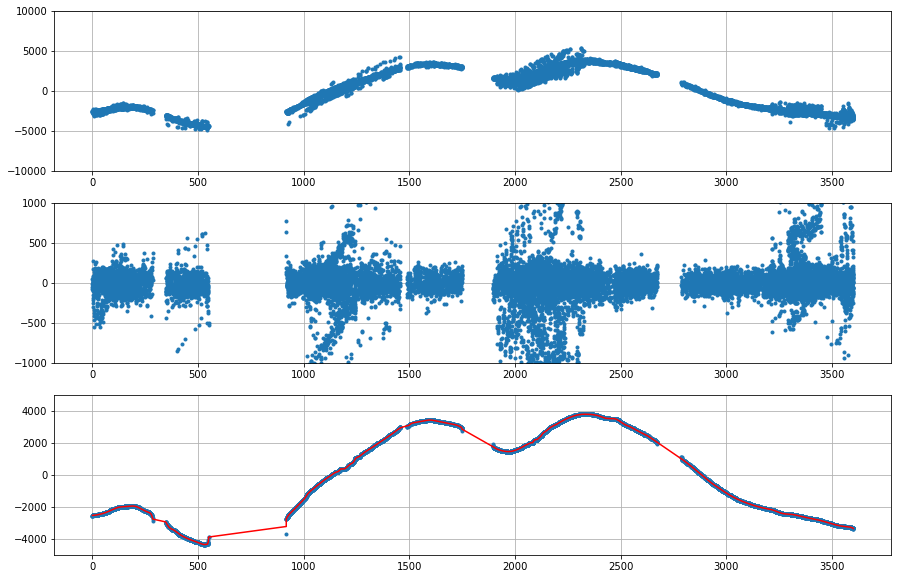

In [195]:
sss.check_result(ylim3=[-5e3, 5e3])

In [200]:
sss.save()

In [530]:
sss = another_run(200, bad, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/35 [00:00<?, ?it/s]

Good station 434: error=22.99m, distance=28.6m
Good station 434: error=22.87m, distance=1.326m


  3%|▎         | 1/35 [01:04<36:44, 64.83s/it]

Good station 434: error=22.9m, distance=0.08844m
Good station 552: error=18.99m, distance=40.04m
Good station 552: error=18.97m, distance=0.4631m


  6%|▌         | 2/35 [02:13<37:01, 67.32s/it]

Good station 552: error=18.99m, distance=0.1419m


 26%|██▌       | 9/35 [02:15<04:18,  9.96s/it]

Station 597 has less than 15000 points, skip


 29%|██▊       | 10/35 [02:16<03:36,  8.68s/it]

Station 165 has less than 15000 points, skip


 31%|███▏      | 11/35 [02:18<02:57,  7.40s/it]

Station 698 has less than 15000 points, skip


 40%|████      | 14/35 [02:19<01:32,  4.41s/it]

Station 423 has less than 15000 points, skip


 63%|██████▎   | 22/35 [02:19<00:22,  1.73s/it]

Station 711 has less than 15000 points, skip


 69%|██████▊   | 24/35 [02:21<00:16,  1.51s/it]

Station 477 has less than 15000 points, skip


 74%|███████▍  | 26/35 [02:22<00:11,  1.33s/it]

Station 623 has less than 15000 points, skip


 83%|████████▎ | 29/35 [02:44<00:19,  3.22s/it]

Station 439: Large time gap of 262.5, error 24.83m, skip


100%|██████████| 35/35 [02:45<00:00,  4.73s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 192


In [201]:
sss = another_run(200, bad, future, max_err=35, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/24 [00:00<?, ?it/s]

Good station 662: error=32.59m, distance=21.49m
Good station 662: error=31.64m, distance=7.384m


  4%|▍         | 1/24 [09:40<3:42:21, 580.06s/it]

Good station 662: error=31.88m, distance=7.739m


 12%|█▎        | 3/24 [09:41<52:46, 150.78s/it]  

Station 597 has less than 15000 points, skip


 17%|█▋        | 4/24 [09:42<32:58, 98.95s/it] 

Station 165 has less than 15000 points, skip


 21%|██        | 5/24 [09:43<21:05, 66.58s/it]

Station 698 has less than 15000 points, skip
Good station 688: error=22.09m, distance=18.22m
Good station 688: error=22.07m, distance=0.9605m


 54%|█████▍    | 13/24 [10:30<03:24, 18.62s/it]

Good station 688: error=22.15m, distance=1.07m


 62%|██████▎   | 15/24 [10:31<02:11, 14.58s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 24/24 [10:31<00:00, 26.32s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 196


In [184]:
future += [591, 535]

In [202]:
sss = another_run(200, bad, [], max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/39 [00:00<?, ?it/s]

Good station 625: error=39.24m, distance=3.397m
Good station 625: error=39.15m, distance=1.697m


  5%|▌         | 2/39 [05:31<1:42:13, 165.76s/it]

Good station 625: error=39.17m, distance=1.149m
Good station 520: error=36.37m, distance=23.51m
Good station 520: error=36.33m, distance=2.16m


  8%|▊         | 3/39 [06:59<1:20:01, 133.39s/it]

Good station 520: error=36.15m, distance=3.334m


 10%|█         | 4/39 [07:23<54:03, 92.67s/it]   

Bad station: 673: error=40.66m


 13%|█▎        | 5/39 [07:49<39:17, 69.33s/it]

Bad station: 367: error=42.15m
Good station 290: error=31.8m, distance=23.88m
Good station 290: error=31.84m, distance=1.466m


 15%|█▌        | 6/39 [08:48<36:12, 65.82s/it]

Good station 290: error=31.82m, distance=0.3129m
Good station 570: error=36.28m, distance=79.09m
Good station 570: error=36.28m, distance=4.339m


 18%|█▊        | 7/39 [09:32<31:27, 58.99s/it]

Good station 570: error=36.34m, distance=1.652m
Good station 591: error=35.71m, distance=17.77m
Good station 591: error=34.46m, distance=0.8476m


 21%|██        | 8/39 [49:24<6:49:55, 793.41s/it]

Good station 591: error=34.58m, distance=1.264m


 28%|██▊       | 11/39 [49:57<2:40:33, 344.04s/it]

Bad station: 669: error=40.48m
Good station 375: error=36.52m, distance=519.4m
Good station 375: error=36.83m, distance=2.537m


 31%|███       | 12/39 [51:32<2:10:45, 290.59s/it]

Good station 375: error=36.49m, distance=2.568m


 33%|███▎      | 13/39 [51:42<1:37:20, 224.63s/it]

Bad station: 535: error=44.9m


 36%|███▌      | 14/39 [51:43<1:10:11, 168.47s/it]

Station 597 has less than 15000 points, skip
Good station 442: error=38.29m, distance=42.32m
Good station 442: error=38.36m, distance=1.01m


 38%|███▊      | 15/39 [52:21<53:38, 134.08s/it]  

Good station 442: error=38.26m, distance=0.769m


 41%|████      | 16/39 [52:22<37:26, 97.67s/it] 

Station 165 has less than 15000 points, skip


 44%|████▎     | 17/39 [52:45<28:02, 76.48s/it]

Station 162: Large time gap of 47.59, error 36.94m, skip


 46%|████▌     | 18/39 [52:46<19:11, 54.86s/it]

Station 698 has less than 15000 points, skip
Good station 689: error=36.55m, distance=26.96m
Good station 689: error=36.59m, distance=2.485m


 56%|█████▋    | 22/39 [54:36<10:45, 37.99s/it]

Good station 689: error=36.64m, distance=9.28m


 72%|███████▏  | 28/39 [54:37<02:59, 16.35s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 39/39 [54:37<00:00, 84.04s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 204


In [543]:
future = [357, 346, 265, 619]

In [ ]:
sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad+future, N=Nsearch)

In [219]:
# checked all stations > 40m:
### 625, 367, 591, 669, 535, 442, 357, 346, 265, 619

# + gaps:
### 162

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(162)
sss.prepare_data(tracks, st, 162, 20000)
sss.optimize()

Number of synchronized stations= 206


Median error: 36.49m using s=3.5e-12
Max time gap: 34.96s
Delta distance: 61.59m


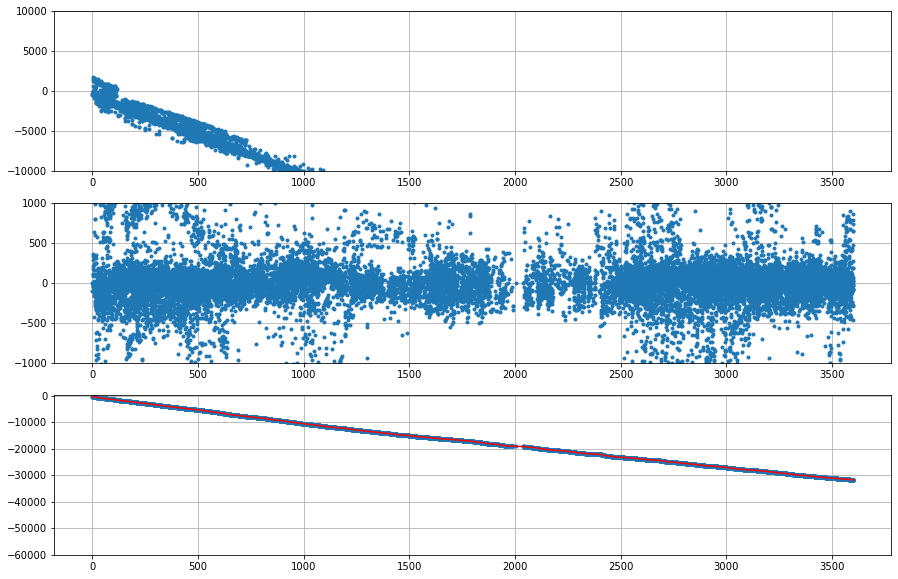

In [220]:
sss.check_result(ylim3=[-6e4, 3e2])

In [221]:
sss.save()

## added: 625, 367, 591, 442, 162
## the last: 669 (41.48m), 535 (44.83m), 357 (48.74m)
## rejected: 346, 265, 478, 439, 619

In [223]:
#bad += [346, 265, 478, 439, 619]
#future = [669, 535, 357]
future = [535]

In [222]:
sss = another_run(200, bad, [], max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/33 [00:00<?, ?it/s]

Good station 587: error=28.39m, distance=23.41m
Good station 587: error=28.27m, distance=0.6042m


  3%|▎         | 1/33 [00:47<25:31, 47.85s/it]

Good station 587: error=28.36m, distance=0.2096m
Good station 425: error=34.83m, distance=63.69m
Good station 425: error=34.87m, distance=0.6938m


 15%|█▌        | 5/33 [01:32<07:47, 16.71s/it]

Good station 425: error=35.05m, distance=1.448m
Good station 669: error=39.24m, distance=25.2m
Good station 669: error=39.5m, distance=0.633m


 18%|█▊        | 6/33 [03:22<17:18, 38.45s/it]

Good station 669: error=39.29m, distance=2.206m


 21%|██        | 7/33 [03:34<13:42, 31.64s/it]

Bad station: 535: error=44.56m


 24%|██▍       | 8/33 [03:35<09:50, 23.60s/it]

Station 597 has less than 15000 points, skip


 33%|███▎      | 11/33 [03:49<04:59, 13.62s/it]

Station 165: Large time gap of 177.5, error 27.25m, skip


 36%|███▋      | 12/33 [03:50<03:54, 11.17s/it]

Station 698 has less than 15000 points, skip
Good station 604: error=27.14m, distance=7.696m
Good station 604: error=27.07m, distance=0.9642m


 39%|███▉      | 13/33 [05:03<08:20, 25.01s/it]

Good station 604: error=27.24m, distance=0.03711m


 64%|██████▎   | 21/33 [05:04<01:25,  7.08s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 33/33 [05:04<00:00,  9.24s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 211


In [224]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(165)
sss.prepare_data(tracks, st, 165, 20000)
sss.optimize()

Number of synchronized stations= 211


Median error: 27.19m using s=7e-12
Max time gap: 177.5s
Delta distance: 38.55m


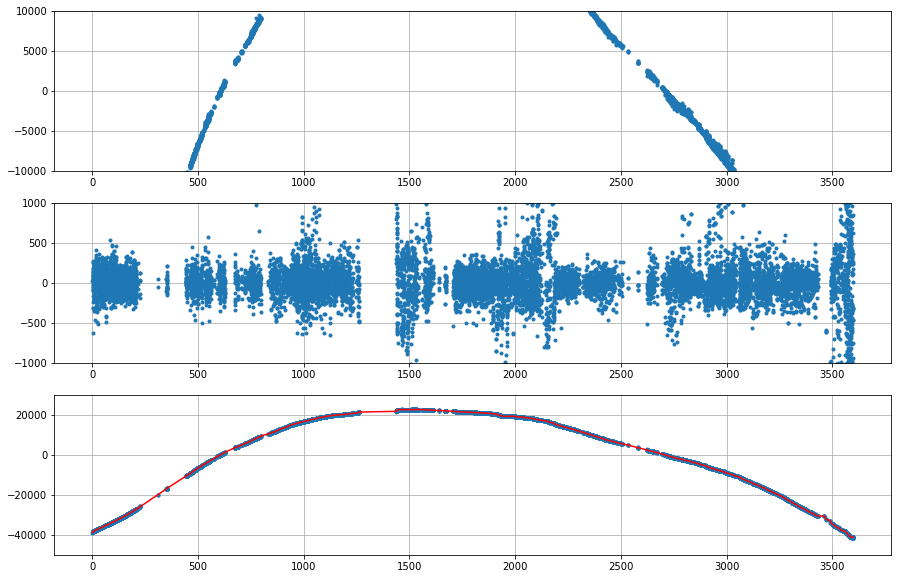

In [225]:
sss.check_result(ylim3=[-5e4, 3e4])

In [226]:
sss.save()

In [43]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(623)
sss.prepare_data(tracks, st, 623, 20000)
sss.optimize()

Number of synchronized stations= 211


Median error: 28.11m using s=2.5e-12
Max time gap: 171.5s
Delta distance: 51.59m


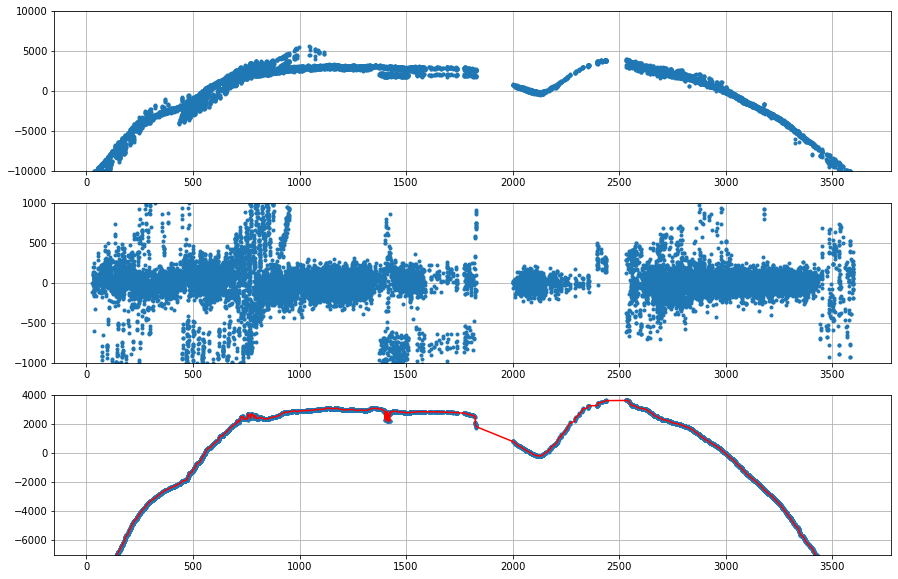

In [47]:
sss.check_result(ylim3=[-7e3, 4e3])

In [48]:
future += [623]

In [237]:
sss = another_run(200, bad, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/27 [00:00<?, ?it/s]

Good station 293: error=29.07m, distance=22.05m
Good station 293: error=28.88m, distance=2.228m


  4%|▎         | 1/27 [00:45<19:35, 45.22s/it]

Good station 293: error=28.79m, distance=0.5915m
Good station 600: error=27.38m, distance=19.93m
Good station 600: error=27.17m, distance=1.298m


  7%|▋         | 2/27 [02:14<29:40, 71.20s/it]

Good station 600: error=27.16m, distance=0.06224m


 19%|█▊        | 5/27 [02:15<07:30, 20.48s/it]

Station 597 has less than 15000 points, skip
Good station 319: error=21.41m, distance=17.51m
Good station 319: error=21.35m, distance=0.2539m


 22%|██▏       | 6/27 [03:04<09:42, 27.75s/it]

Good station 319: error=21.37m, distance=1.221m
Good station 452: error=30.66m, distance=7.121m
Good station 452: error=30.61m, distance=4.478m


 26%|██▌       | 7/27 [03:49<10:43, 32.18s/it]

Good station 452: error=30.59m, distance=2.082m


 30%|██▉       | 8/27 [03:50<07:28, 23.59s/it]

Station 698 has less than 15000 points, skip


 59%|█████▉    | 16/27 [03:50<01:03,  5.73s/it]

Station 711 has less than 15000 points, skip


 78%|███████▊  | 21/27 [04:11<00:30,  5.08s/it]

Bad station: 574: error=42.42m


100%|██████████| 27/27 [04:11<00:00,  9.32s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 216


In [53]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(619)
sss.prepare_data(tracks, st, 619, 20000)
sss.optimize()

Number of synchronized stations= 215


Median error: 47.27m using s=2.05e-11
Max time gap: 5.76s
Delta distance: 55.25m


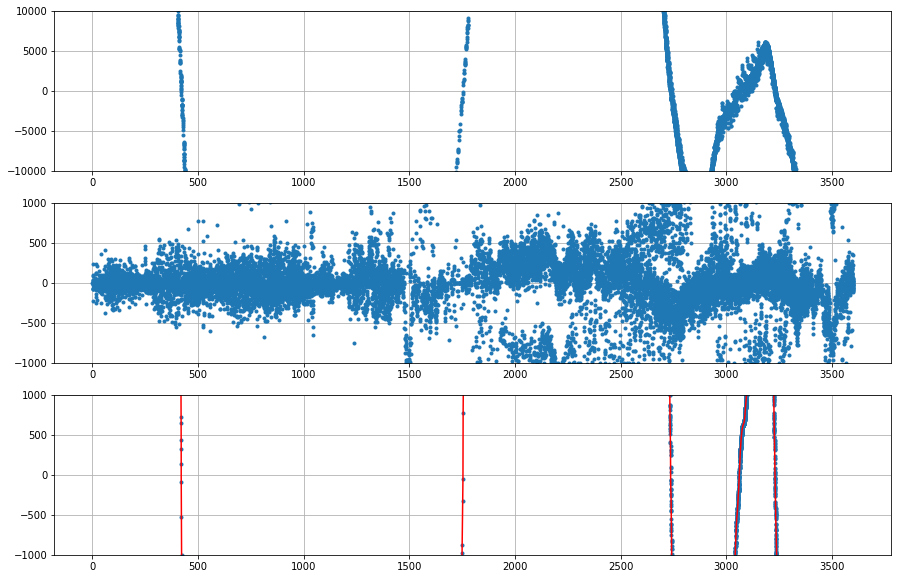

In [54]:
sss.check_result()

In [55]:
bad += [619]

In [246]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

# 574
st.add_station(565)
sss.prepare_data(tracks, st, 565, 20000)
sss.optimize()

Number of synchronized stations= 218


Median error: 41.04m using s=3.5e-12
Max time gap: 3.384s
Delta distance: 42.78m


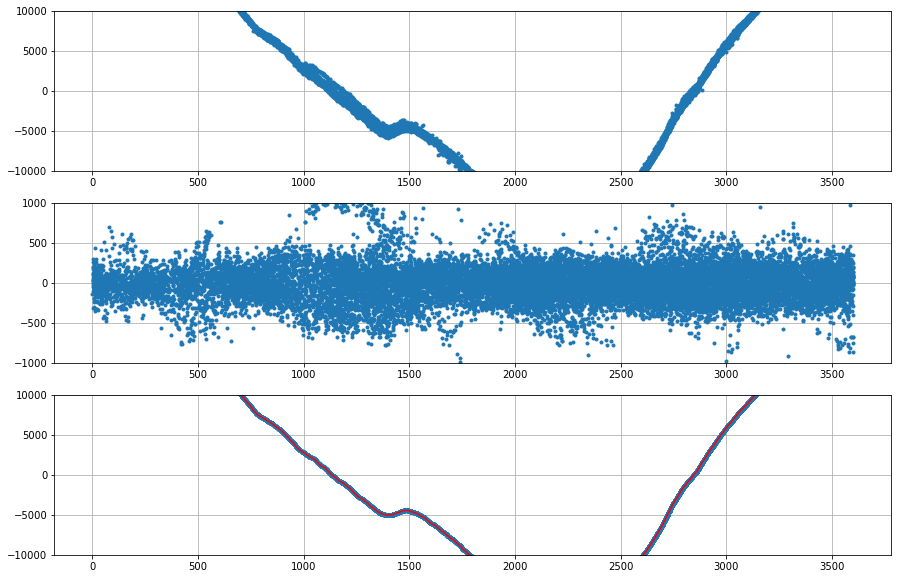

In [248]:
sss.check_result(ylim3=[-1e4, 1e4])

In [249]:
sss.save()

In [245]:
sss = another_run(200, bad, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/22 [00:00<?, ?it/s]

Good station 87: error=33.02m, distance=8.303m
Good station 87: error=32.98m, distance=0.9199m


  9%|▉         | 2/22 [01:42<17:05, 51.28s/it]

Good station 87: error=33.11m, distance=0.351m


 14%|█▎        | 3/22 [01:43<09:36, 30.36s/it]

Station 597 has less than 15000 points, skip


 18%|█▊        | 4/22 [01:44<05:49, 19.42s/it]

Station 698 has less than 15000 points, skip


 45%|████▌     | 10/22 [02:06<01:28,  7.41s/it]

Bad station: 565: error=41.3m


 59%|█████▉    | 13/22 [02:07<00:43,  4.86s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 22/22 [02:07<00:00,  5.80s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 218


In [250]:
sss = another_run(200, bad, future, max_err=40, N=15000, n_new_stations=3)
!rm stations_params2.json stations_params3.json stations_params4.json

  0%|          | 0/20 [00:00<?, ?it/s]

Good station 251: error=25.78m, distance=23.77m
Good station 251: error=25.85m, distance=1.349m


  5%|▌         | 1/20 [00:48<15:24, 48.68s/it]

Good station 251: error=25.79m, distance=0.0855m


 10%|█         | 2/20 [00:49<06:12, 20.67s/it]

Station 597 has less than 15000 points, skip


 15%|█▌        | 3/20 [00:50<03:19, 11.72s/it]

Station 698 has less than 15000 points, skip


 55%|█████▌    | 11/20 [00:51<00:17,  1.94s/it]

Station 711 has less than 15000 points, skip


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 220


In [251]:
sss = another_run(200, bad, future, max_err=40, N=15000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  5%|▌         | 1/19 [00:01<00:18,  1.01s/it]

Station 597 has less than 15000 points, skip


 11%|█         | 2/19 [00:02<00:17,  1.00s/it]

Station 698 has less than 15000 points, skip


 16%|█▌        | 3/19 [00:02<00:14,  1.11it/s]

Station 705 has less than 15000 points, skip
Good station 683: error=30.53m, distance=59.58m
Good station 683: error=30.43m, distance=0.2786m


 21%|██        | 4/19 [01:56<11:23, 45.60s/it]

Good station 683: error=30.83m, distance=4.74m


 26%|██▋       | 5/19 [01:57<06:51, 29.36s/it]

Station 84 has less than 15000 points, skip
Good station 264: error=31.39m, distance=20.68m
Good station 264: error=31.16m, distance=1.081m


 37%|███▋      | 7/19 [03:16<06:54, 34.54s/it]

Good station 264: error=30.96m, distance=0.6156m


 53%|█████▎    | 10/19 [03:17<02:29, 16.63s/it]

Station 711 has less than 15000 points, skip


 68%|██████▊   | 13/19 [03:17<00:57,  9.61s/it]

Station 608 has less than 15000 points, skip


 74%|███████▎  | 14/19 [03:18<00:40,  8.11s/it]

Station 135 has less than 15000 points, skip


 84%|████████▍ | 16/19 [03:19<00:16,  5.59s/it]

Station 309 has less than 15000 points, skip


100%|██████████| 19/19 [03:19<00:00, 10.50s/it]

Station 287 has less than 15000 points, skip
Number of synchronized stations= 222


In [252]:
sss = another_run(100, bad, future, max_err=40, N=15000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▎         | 1/27 [00:28<12:10, 28.09s/it]

Station 698: Large time gap of 187.3, error 26.41m, skip


  7%|▋         | 2/27 [00:56<11:45, 28.21s/it]

Station 597: Large time gap of 179.7, error 23.56m, skip


 11%|█         | 3/27 [00:57<06:21, 15.88s/it]

Station 705 has less than 15000 points, skip
Good station 603: error=36.79m, distance=25.73m
Good station 603: error=36.54m, distance=0.9279m


 15%|█▍        | 4/27 [01:54<12:14, 31.93s/it]

Good station 603: error=36.59m, distance=2.309m


 19%|█▊        | 5/27 [01:54<07:35, 20.69s/it]

Station 84 has less than 15000 points, skip


 22%|██▏       | 6/27 [01:55<04:50, 13.83s/it]

Station 282 has less than 15000 points, skip


 26%|██▌       | 7/27 [01:56<03:10,  9.54s/it]

Station 287 has less than 15000 points, skip


 30%|██▉       | 8/27 [01:56<02:05,  6.61s/it]

Station 493 has less than 15000 points, skip


 37%|███▋      | 10/27 [01:56<01:00,  3.55s/it]

Station 239 has less than 15000 points, skip


 44%|████▍     | 12/27 [01:58<00:36,  2.43s/it]

Station 711 has less than 15000 points, skip


 52%|█████▏    | 14/27 [01:58<00:20,  1.62s/it]

Station 606 has less than 15000 points, skip


 56%|█████▌    | 15/27 [01:59<00:17,  1.47s/it]

Station 682 has less than 15000 points, skip


 59%|█████▉    | 16/27 [02:00<00:13,  1.25s/it]

Station 608 has less than 15000 points, skip


 63%|██████▎   | 17/27 [02:00<00:11,  1.12s/it]

Station 318 has less than 15000 points, skip


 67%|██████▋   | 18/27 [02:02<00:09,  1.11s/it]

Station 33 has less than 15000 points, skip


 70%|███████   | 19/27 [02:03<00:09,  1.19s/it]

Station 135 has less than 15000 points, skip


 74%|███████▍  | 20/27 [02:04<00:09,  1.29s/it]

Station 506 has less than 15000 points, skip


 78%|███████▊  | 21/27 [02:08<00:11,  1.87s/it]

Station 309 has less than 15000 points, skip


 81%|████████▏ | 22/27 [02:08<00:07,  1.44s/it]

Station 30 has less than 15000 points, skip


 85%|████████▌ | 23/27 [02:10<00:05,  1.48s/it]

Station 230 has less than 15000 points, skip


 89%|████████▉ | 24/27 [02:12<00:04,  1.64s/it]

Station 35 has less than 15000 points, skip


 93%|█████████▎| 25/27 [02:12<00:02,  1.27s/it]

Station 609 has less than 15000 points, skip


100%|██████████| 27/27 [02:14<00:00,  4.98s/it]

Station 380 has less than 15000 points, skip
Number of synchronized stations= 223


In [78]:
bad += [281]

In [253]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(597)
sss.prepare_data(tracks, st, 597, 20000)
sss.optimize()

Number of synchronized stations= 223


Median error: 23.31m using s=2e-12
Max time gap: 179.7s
Delta distance: 755.7m


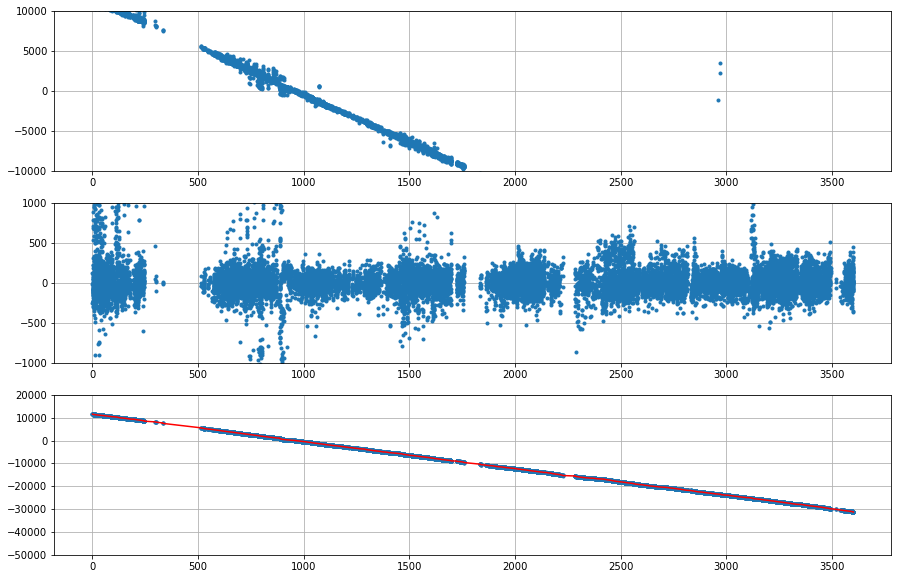

In [256]:
sss.check_result(ylim3=[-5e4, 2e4])

In [257]:
sss.save()

In [262]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(698)
sss.prepare_data(tracks, st, 698, 20000)
sss.optimize()

Number of synchronized stations= 224


Median error: 26.49m using s=5e-12
Max time gap: 187.3s
Delta distance: 20.04m


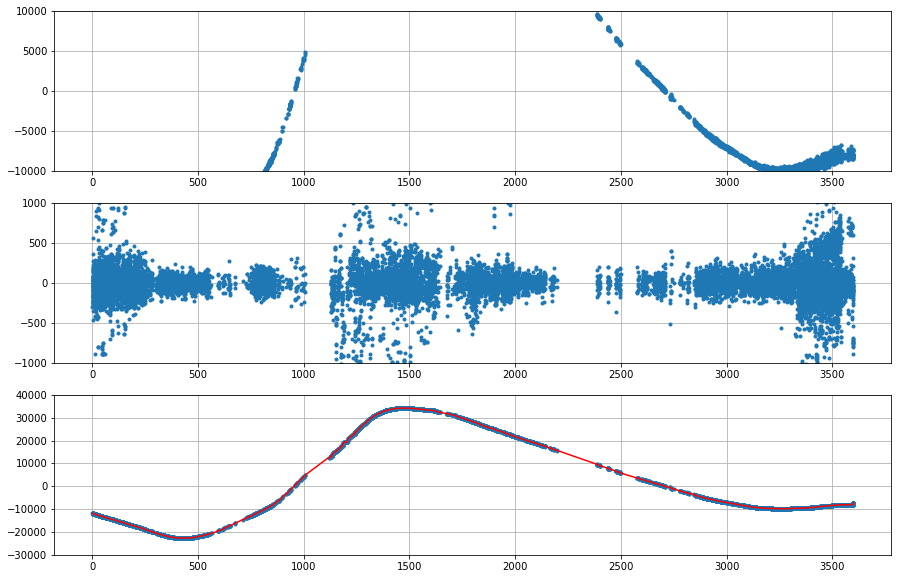

In [263]:
sss.check_result(ylim3=[-3e4, 4e4])

In [264]:
sss.save()

In [265]:
sss = another_run(100, bad, future, max_err=40, N=10000, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▍         | 1/24 [00:01<00:27,  1.20s/it]

Station 705 has less than 10000 points, skip


  8%|▊         | 2/24 [00:01<00:20,  1.07it/s]

Station 84 has less than 10000 points, skip


 12%|█▎        | 3/24 [00:02<00:18,  1.15it/s]

Station 282 has less than 10000 points, skip


 17%|█▋        | 4/24 [00:03<00:16,  1.20it/s]

Station 287 has less than 10000 points, skip


 21%|██        | 5/24 [00:03<00:12,  1.54it/s]

Station 493 has less than 10000 points, skip


 29%|██▉       | 7/24 [00:04<00:06,  2.44it/s]

Station 239 has less than 10000 points, skip


 38%|███▊      | 9/24 [00:05<00:08,  1.86it/s]

Station 711 has less than 10000 points, skip


 46%|████▌     | 11/24 [00:06<00:05,  2.44it/s]

Station 606 has less than 10000 points, skip


 50%|█████     | 12/24 [00:06<00:05,  2.13it/s]

Station 682 has less than 10000 points, skip


 54%|█████▍    | 13/24 [00:07<00:05,  2.09it/s]

Station 608 has less than 10000 points, skip


 58%|█████▊    | 14/24 [00:07<00:05,  1.86it/s]

Station 318 has less than 10000 points, skip


 62%|██████▎   | 15/24 [00:09<00:06,  1.31it/s]

Station 33 has less than 10000 points, skip


 67%|██████▋   | 16/24 [00:10<00:07,  1.06it/s]

Station 135 has less than 10000 points, skip


 71%|███████   | 17/24 [00:12<00:07,  1.09s/it]

Station 506 has less than 10000 points, skip


 75%|███████▌  | 18/24 [00:19<00:16,  2.74s/it]

Station 309: Large time gap of 107.8, error 23.3m, skip


 79%|███████▉  | 19/24 [00:19<00:10,  2.04s/it]

Station 30 has less than 10000 points, skip


 83%|████████▎ | 20/24 [00:20<00:07,  1.76s/it]

Station 230 has less than 10000 points, skip


 88%|████████▊ | 21/24 [00:22<00:05,  1.86s/it]

Station 35 has less than 10000 points, skip


 92%|█████████▏| 22/24 [00:22<00:02,  1.42s/it]

Station 609 has less than 10000 points, skip


100%|██████████| 24/24 [00:24<00:00,  1.02s/it]

Station 380 has less than 10000 points, skip


FileNotFoundError: [Errno 2] No such file or directory: 'stations_params2.json'

In [266]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

st.add_station(309)
sss.prepare_data(tracks, st, 309, 20000)
sss.optimize()

Number of synchronized stations= 225


Median error: 23.17m using s=2.5e-12
Max time gap: 106.6s
Delta distance: 23.07m


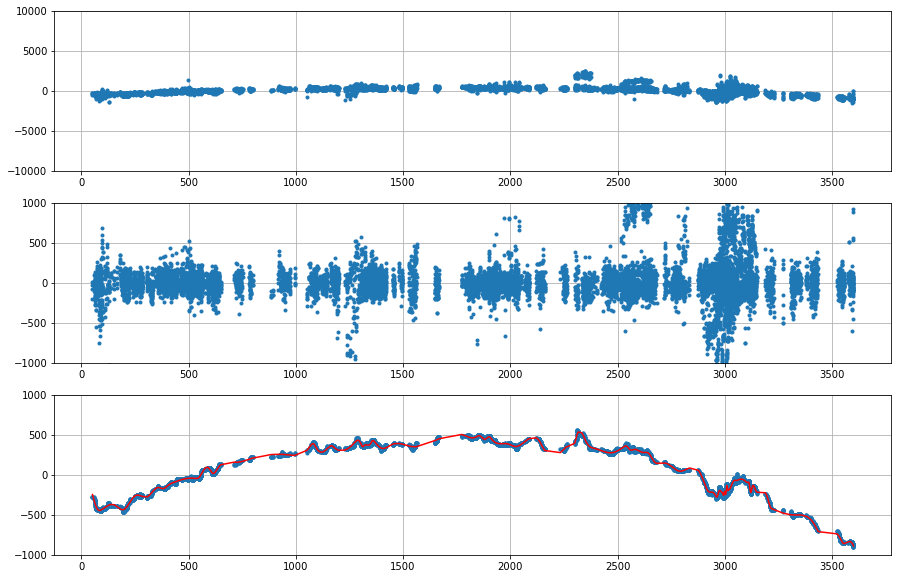

In [267]:
sss.check_result(ylim2=[-1e3, 1e3], ylim3=[-1e3, 1e3])

In [268]:
sss.save()

In [103]:
bad += [220, 423]

In [269]:
sss = another_run(100, bad, future, max_err=40, N=7500, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▍         | 1/23 [00:27<10:06, 27.58s/it]

Station 705: Large time gap of 56.9, error 24.0m, skip


  9%|▊         | 2/23 [00:50<08:47, 25.12s/it]

Station 84: Large time gap of 158.1, error 11.3m, skip


 13%|█▎        | 3/23 [00:51<04:38, 13.94s/it]

Station 282 has less than 7500 points, skip


 17%|█▋        | 4/23 [00:52<02:45,  8.72s/it]

Station 287 has less than 7500 points, skip


 22%|██▏       | 5/23 [00:52<01:42,  5.69s/it]

Station 493 has less than 7500 points, skip


 30%|███       | 7/23 [00:53<00:46,  2.90s/it]

Station 239 has less than 7500 points, skip


 39%|███▉      | 9/23 [01:49<03:10, 13.60s/it]

Station 711: Large time gap of 228.2, error 38.45m, skip


 48%|████▊     | 11/23 [01:50<01:42,  8.57s/it]

Station 606 has less than 7500 points, skip


 52%|█████▏    | 12/23 [01:50<01:16,  6.93s/it]

Station 682 has less than 7500 points, skip


 57%|█████▋    | 13/23 [01:51<00:54,  5.45s/it]

Station 608 has less than 7500 points, skip


 61%|██████    | 14/23 [01:52<00:38,  4.27s/it]

Station 318 has less than 7500 points, skip


 65%|██████▌   | 15/23 [01:53<00:27,  3.49s/it]

Station 33 has less than 7500 points, skip
Good station 135: error=39.62m, distance=97.73m
Good station 135: error=39.2m, distance=3.057m


 70%|██████▉   | 16/23 [02:12<00:54,  7.75s/it]

Good station 135: error=39.2m, distance=0.06855m


 74%|███████▍  | 17/23 [02:14<00:35,  5.99s/it]

Station 506 has less than 7500 points, skip


 78%|███████▊  | 18/23 [02:14<00:21,  4.39s/it]

Station 30 has less than 7500 points, skip


 83%|████████▎ | 19/23 [02:15<00:13,  3.46s/it]

Station 230 has less than 7500 points, skip


 87%|████████▋ | 20/23 [02:24<00:15,  5.10s/it]

Bad station: 35: error=40.98m


 91%|█████████▏| 21/23 [02:25<00:07,  3.74s/it]

Station 609 has less than 7500 points, skip


100%|██████████| 23/23 [02:27<00:00,  6.40s/it]

Station 380 has less than 7500 points, skip
Number of synchronized stations= 227


In [611]:
#bad += [477]
#future

#for s in st_params_old:
#    if s not in st_params:
#        print(s)

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    

for s in st_params:
    if 'gaps' in st_params[s]:
        print(s, st_params[s]['gaps'])
    
#st_params['681']['med_error']
#st_params['679']['gaps'] = [[59.095933202409554, 100.82349411134682], [638.9395948772218, 695.6625731700677], [1272.8761639449954, 1308.3761280880399]]
#st_params['478']['gaps'] = st_params['478']['gaps'] + [[2300, 2700]] + [[2850, 3000]]
#st_params['597']['gaps'] = [[245.70994547740824, 296.14923495909005], [299.9601041814003, 515.4387522917215], [1758.979741784161, 1836.7052672867324], [2223.6876851257325, 2285.2896952474857]]

240
678 [[244.1083009811077, 290.65398424099214]]
455 [[602.2623683855517, 725.4185003707512]]
657 [[352.89827752294855, 563.1071042875569]]
679 [[59.05188184505354, 100.8234942526139], [638.939594898283, 695.7124353759145], [1272.7202707886447, 1308.3859837199873], [2044.6645841319491, 2082.201581067381], [3224.3659184431394, 3264.6616788696515]]
596 [[2487.3497663626854, 3600]]
512 [[1782.9256273927042, 1850.7909123560655]]
667 [[2630.0771526674216, 2682.1020063972237]]
681 [[735.1782158687608, 920.0590031007541], [1500, 2348.2490500351814]]
675 [[1482.3041864824102, 1753.237260465611]]
441 [[404.05311765327195, 508.57841420080905]]
253 [[360.27027390420517, 396.0562054558586], [1265.3559185182423, 1361.136347033866]]
368 [[285.5194479329179, 348.56993812279717], [549.2447752165142, 918.6142569716227], [1456.861937535036, 1487.6634039858927], [1748.791158387961, 1897.34221452447], [2673.176546128131, 2786.722220454573]]
162 [[2002.3945838974212, 2039.3522582776666]]
669 [[0, 500]]
16

In [ ]:
ii = np.where(np.fabs(np.diff(st_params['265']['spl_coefs'])) > 0.001)[0]
jj = [ii[0]]

for i in range(1, len(ii)):
    print(ii[i], ii[i-1])
    if ii[i] - ii[i-1] > 1:
        jj.append(ii[i])

gaps = []
for i in np.array(st_params['265']['spl_knots'])[jj]:
    gaps += [[max(i-5, 0), min(i+5, 3600)]]
gaps

In [609]:
with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

In [605]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
del st_params['597']
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

# add stations [669, 535, 357, 623]

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, [], N=200)

# 265, 478, 535, 357, 623, 33, 35, 669, 439

## !!!added gaps for 265, 478, 669

st.add_station(597)
sss.prepare_data(tracks, st, 597, 20000)
sss.optimize()

  2%|▏         | 56/2629 [00:00<00:04, 557.10it/s]

Number of synchronized stations= 239


100%|██████████| 2629/2629 [00:02<00:00, 1079.68it/s]


Median error: 19.4m using s=2e-12
Max time gap: 179.7s
Delta distance: 749.8m


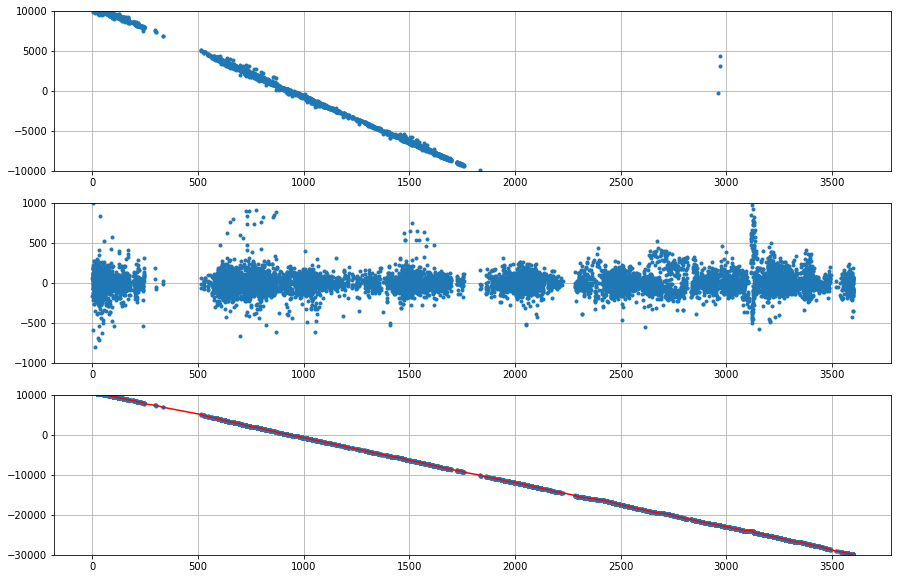

In [606]:
sss.check_result(ylim2=[-1e3, 1e3], ylim3=[-3e4, 1e4])
#plt.xlim([3400, 3600])

In [607]:
#sss.save()
#bad += [623, 357] 214, 635

if True:
    if True:
        if True:
            ind = (np.concatenate([np.array([i, i+1]) for i in np.where(np.diff(sss.t1_1) > 25)[0]])).tolist()
            
            indent = 1  # [s]
            gaps = []
            for i in range(0, len(ind), 2):
                gaps.append([sss.t1_1[ind[i]]-indent, sss.t1_1[ind[i+1]]+indent])

            if sss.t1_1[0] > 25:
                gaps = [[0, sss.t1_1[0]+indent]] + gaps

            if sss.t1_1[-1] < 3600 - 25:
                gaps = gaps + [[sss.t1_1[-1]-indent, 3600]]
                
            print(gaps)
            ## join small gaps together
            new_gaps = []
            curr_gap = copy.copy(gaps[0])
            N, i = len(gaps), 1
            while i < N:
                if curr_gap[1] - gaps[i][0] < 50:
                    curr_gap[1] = gaps[i][1]
                else:
                    new_gaps += [curr_gap]
                    curr_gap = copy.copy(gaps[i])

                i += 1
    
            new_gaps += [curr_gap]

print(new_gaps)

[[245.70994547740824, 296.14923495909005], [299.9601041814003, 334.6402679644423], [333.7403814716972, 515.4387522917215], [1758.979741784161, 1836.7052672867324], [2223.6876851257325, 2285.2896952474857]]
[[245.70994547740824, 2285.2896952474857]]


In [612]:
sss = another_run(100, bad, [], max_err=40, N=7500, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  5%|▍         | 1/22 [00:00<00:10,  2.06it/s]

Station 282 has less than 7500 points, skip


  9%|▉         | 2/22 [00:01<00:11,  1.72it/s]

Station 287 has less than 7500 points, skip


 14%|█▎        | 3/22 [00:01<00:09,  1.96it/s]

Station 493 has less than 7500 points, skip


 23%|██▎       | 5/22 [00:01<00:05,  3.09it/s]

Station 239 has less than 7500 points, skip


 32%|███▏      | 7/22 [04:27<14:52, 59.53s/it]

Bad station: 711: error=45.78m


 41%|████      | 9/22 [04:27<07:53, 36.40s/it]

Station 606 has less than 7500 points, skip


 45%|████▌     | 10/22 [04:29<05:47, 28.92s/it]

Bad station: 30: error=nanm


 50%|█████     | 11/22 [04:52<05:03, 27.55s/it]

Station 268: Large time gap of 81.74, error 34.41m, skip


 59%|█████▉    | 13/22 [04:53<02:29, 16.57s/it]

Station 682 has less than 7500 points, skip


 64%|██████▎   | 14/22 [04:54<01:43, 12.99s/it]

Station 608 has less than 7500 points, skip


 68%|██████▊   | 15/22 [04:54<01:10, 10.00s/it]

Station 318 has less than 7500 points, skip


 73%|███████▎  | 16/22 [04:56<00:46,  7.81s/it]

Station 506 has less than 7500 points, skip


 77%|███████▋  | 17/22 [04:57<00:30,  6.03s/it]

Station 230 has less than 7500 points, skip


 86%|████████▋ | 19/22 [04:58<00:10,  3.49s/it]

Station 609 has less than 7500 points, skip


100%|██████████| 22/22 [04:59<00:00, 13.62s/it]

Station 380 has less than 7500 points, skip


FileNotFoundError: [Errno 2] No such file or directory: 'stations_params2.json'

In [7]:
#bad = [205, 259, 296, 222, 207, 695, 700, 525, 699, 461, 605, 295, 671] + [377, 577, 641, 312, 702, 214, 635] + [281, 477, 265, 220]
q = [346, 478, 439, 619, 423, 623, 357]


bad = [205, 259, 296, 222, 207, 695, 700, 525, 699, 461, 605, 295, 671] + [377, 577, 641, 312, 702, 214, 635] + [281, 477, 265, 220] + q

[205,
 259,
 296,
 222,
 207,
 695,
 700,
 525,
 699,
 461,
 605,
 295,
 671,
 377,
 577,
 641,
 312,
 702,
 214,
 635,
 281,
 477,
 265,
 220,
 346,
 478,
 439,
 619,
 423,
 623,
 357]

In [266]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

# add stations 346, 478, 439, 619, 423, 623, 357, 705, 84, 135

#sss = SingleStationSolver()
#sss.find_new_stations(tracks, st, bad, N=200)

st.add_station(265)
sss.prepare_data(tracks, st, 265, 20000)
sss.optimize()

Number of synchronized stations= 237


Median error: 47.81m using s=1.4e-11
Max time gap: 2.477s
Delta distance: 51.5m


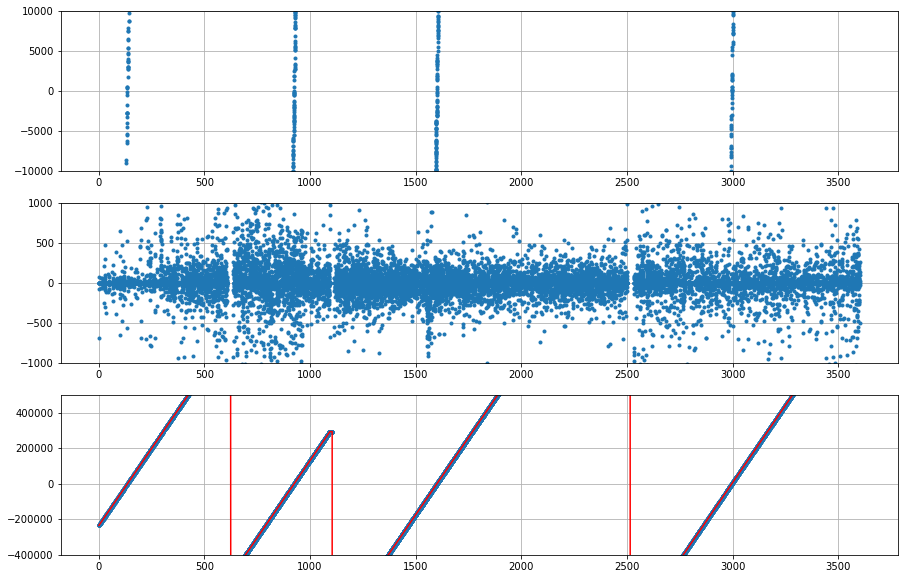

In [268]:
sss.check_result(ylim2=[-1e3, 1e3], ylim3=[-4e5, 5e5])

In [269]:
sss.save()

In [256]:
sss = another_run(100, bad, future, max_err=40, N=7500, n_new_stations=2)
!rm stations_params2.json stations_params3.json stations_params4.json

  4%|▍         | 1/26 [00:09<03:49,  9.16s/it]

Station 220: Large time gap of 333.7, error 34.26m, skip


  8%|▊         | 2/26 [03:24<47:24, 118.52s/it]

Bad station: 265: error=52.07m


 12%|█▏        | 3/26 [03:24<24:46, 64.63s/it] 

Station 282 has less than 7500 points, skip


 15%|█▌        | 4/26 [03:25<14:26, 39.39s/it]

Station 287 has less than 7500 points, skip


 19%|█▉        | 5/26 [03:25<08:51, 25.31s/it]

Station 493 has less than 7500 points, skip


 27%|██▋       | 7/26 [03:34<04:41, 14.80s/it]

Bad station: 35: error=45.77m


 31%|███       | 8/26 [03:35<03:17, 10.96s/it]

Station 239 has less than 7500 points, skip


 38%|███▊      | 10/26 [06:17<10:58, 41.16s/it]

Station 711: Large time gap of 228.2, error 38.12m, skip


 46%|████▌     | 12/26 [06:17<05:57, 25.53s/it]

Station 606 has less than 7500 points, skip


 50%|█████     | 13/26 [06:22<04:34, 21.10s/it]

Bad station: 30: error=nanm


 62%|██████▏   | 16/26 [06:23<01:51, 11.12s/it]

Station 682 has less than 7500 points, skip


 65%|██████▌   | 17/26 [06:23<01:22,  9.15s/it]

Station 608 has less than 7500 points, skip


 69%|██████▉   | 18/26 [06:24<00:59,  7.38s/it]

Station 318 has less than 7500 points, skip


 73%|███████▎  | 19/26 [06:50<01:22, 11.78s/it]

Bad station: 33: error=46.36m


 77%|███████▋  | 20/26 [06:52<00:55,  9.23s/it]

Station 506 has less than 7500 points, skip


 81%|████████  | 21/26 [06:53<00:35,  7.14s/it]

Station 230 has less than 7500 points, skip


 88%|████████▊ | 23/26 [06:54<00:12,  4.20s/it]

Station 609 has less than 7500 points, skip


100%|██████████| 26/26 [06:55<00:00, 16.00s/it]

Station 380 has less than 7500 points, skip


FileNotFoundError: [Errno 2] No such file or directory: 'stations_params2.json'

In [273]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

# add stations 346, 478, 439, 619, 423, 623, 357, 705, 84, 135

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad, N=200)

st.add_station(33)
sss.prepare_data(tracks, st, 33, 20000)
sss.optimize()

  3%|▎         | 78/2629 [00:00<00:03, 757.39it/s]

Number of synchronized stations= 238


100%|██████████| 2629/2629 [00:01<00:00, 1834.77it/s]


Median error: 43.98m using s=1.15e-11
Max time gap: 207.4s
Delta distance: 1.838e+03m


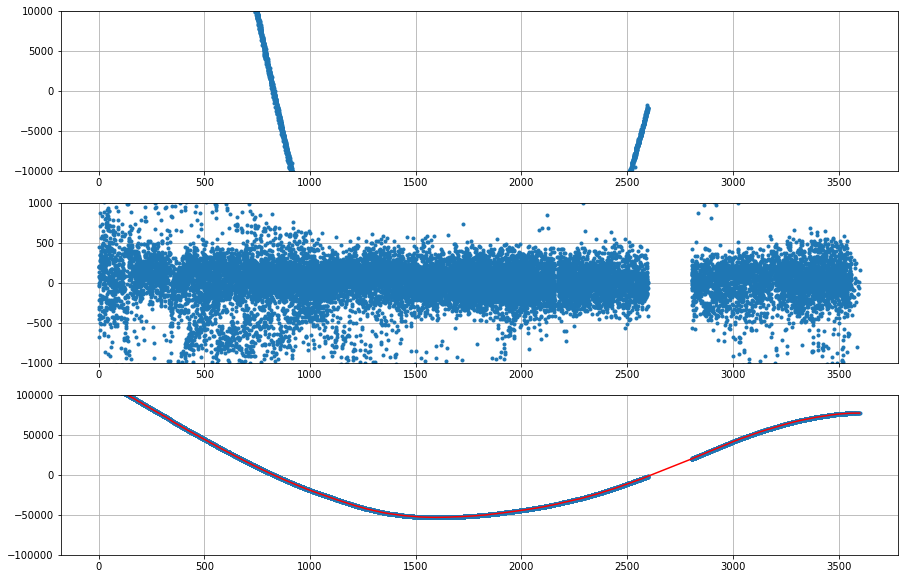

In [275]:
sss.check_result(ylim3=[-1e5, 1e5])

In [276]:
sss.save()

In [277]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

# add stations 346, 478, 439, 619, 423, 623, 357, 705, 84, 135

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad, N=200)

st.add_station(35)
sss.prepare_data(tracks, st, 35, 20000)
sss.optimize()

  3%|▎         | 78/2629 [00:00<00:03, 745.73it/s]

Number of synchronized stations= 239


100%|██████████| 2629/2629 [00:01<00:00, 1641.40it/s]


Median error: 40.08m using s=2e-12
Max time gap: 13.62s
Delta distance: 529.2m


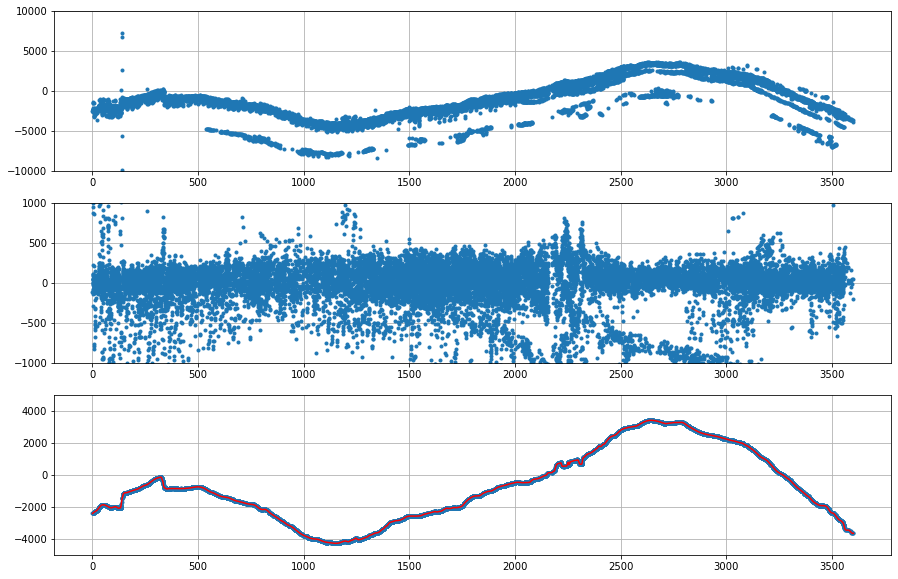

In [281]:
sss.check_result(ylim3=[-5e3, 5e3])

In [282]:
sss.save()

In [ ]:
x

Number of synchronized stations= 240


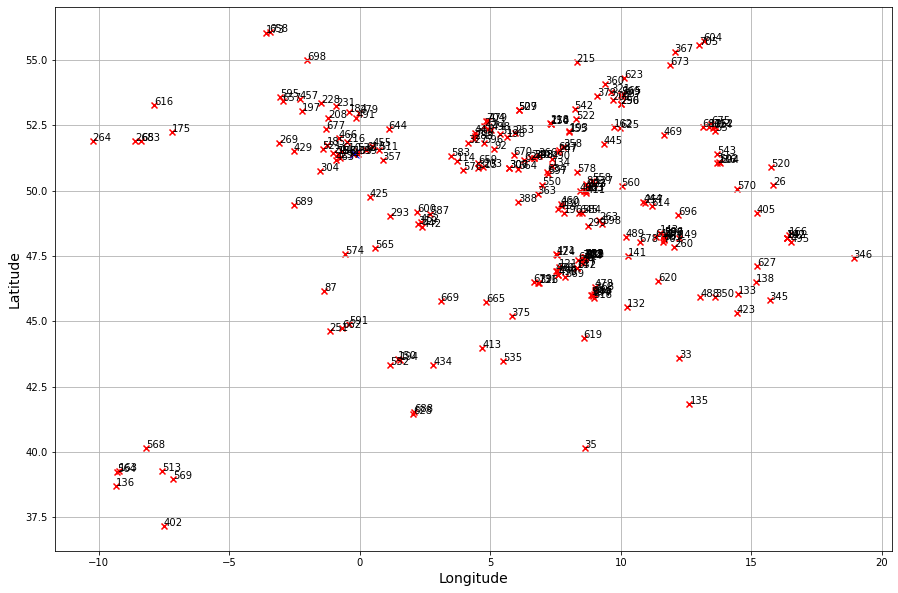

In [613]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

figsize(15, 10)
st.plot()

#q = [705, 84, 282, 287, 493, 239, 711, 606, 682, 608, 318, 33, 135, 506, 30, 230, 35, 609, 380]
#q = [346, 265, 478, 439, 619, 610, 423, 623, 357]
q = [711]

plt.plot(sensors[sensors.serial.isin(q)].longitude,
         sensors[sensors.serial.isin(q)].latitude, 'bx', ms=9)

In [299]:
st_params['357']['med_error']

KeyError: '357'

In [ ]:
x

In [153]:
q = [int(s) for s in st_params if (s not in st_params_old) and (s not in first_set)]

In [ ]:
x

In [ ]:
x

In [300]:
st_params_old['357']['med_error']

49.040684655438646

In [616]:
with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
with open('stations_params_240_stations.json', 'r') as f:
    st_params_old = json.load(f)

In [617]:
diff = []
for s in st_params:
    if s in st_params_old and 'med_error' in st_params[s]:
        diff.append(st_params[s]['med_error'] - st_params_old[s]['med_error'])
        
        if st_params[s]['med_error'] - st_params_old[s]['med_error'] > 2.5:
            print(s, st_params[s]['med_error'], st_params_old[s]['med_error'])
        
diff

277 34.078236198839974 30.703822030250375
131 22.722240609990056 19.25647449668152
565 41.041865962240166 35.46259094795077
683 30.43139867950458 27.039319769254636
265 55.11822068768129 47.81214981356807


[0.017889500682048975,
 0.1080603236052724,
 -0.02987641934615226,
 -0.03583969947414545,
 0.005098898092459336,
 -0.1433833250381582,
 0.01681591887999545,
 -0.016729471445444233,
 0.032258114297267326,
 0.014742679099711609,
 0.014980893339876289,
 0.06624356080536487,
 0.01572430395173896,
 0.00927680037026235,
 -0.10357814562950551,
 -0.0029170601223675874,
 -0.34371547906460975,
 -0.09665760705099657,
 0.07460549457993437,
 0.027764067878340626,
 -0.037469383950327284,
 -0.09223957040164876,
 -0.19849735894113607,
 -0.04369571793344207,
 3.374414168589599,
 -0.32868487695106197,
 0.09318625143842851,
 -0.19913444898732635,
 -0.38234935996755226,
 -0.09798489759309703,
 -0.2865327982444974,
 -0.129401063518511,
 -0.08678092700929341,
 -0.49057912567364426,
 -0.1551959809505945,
 -0.11082442356908828,
 -0.2860965990528719,
 -0.2043320720456947,
 -0.06576160784197072,
 -0.13790047004395944,
 -0.06135258172294655,
 -0.06891805171158083,
 -1.0004293008292606,
 -0.07754890006466653,
 -0

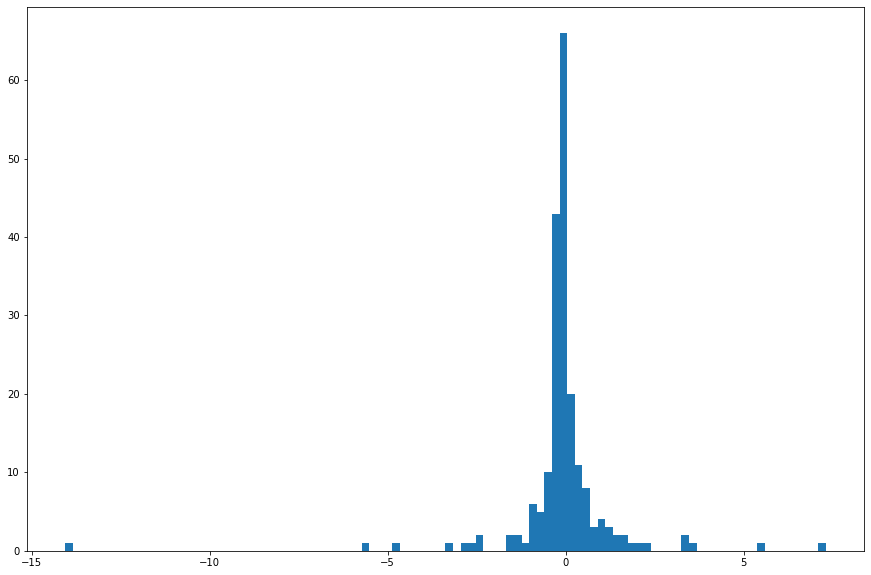

In [618]:
_ = plt.hist(diff, bins=100)

In [620]:
np.median(diff)

-0.09444858872632267

In [145]:
with open('stations_params.json', 'w') as f:
    json.dump(st_params, f)

In [295]:
del st_params['594']

In [297]:
from src.solvers import SingleStationSolver

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)
    
st = Stations([int(s) for s in st_params])
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])
    
st.st_params = st_params

sss = SingleStationSolver()
sss.find_new_stations(tracks, st, bad+future, N=500)
st.add_station(594)
sss.prepare_data(tracks, st, 594, 20000)
sss.optimize()

  3%|▎         | 78/2629 [00:00<00:03, 750.90it/s]

Number of synchronized stations= 139


100%|██████████| 2629/2629 [00:01<00:00, 1743.89it/s]


Median error: 19.04m using s=2e-12
Max time gap: 3.011s
Delta distance: 12.7m


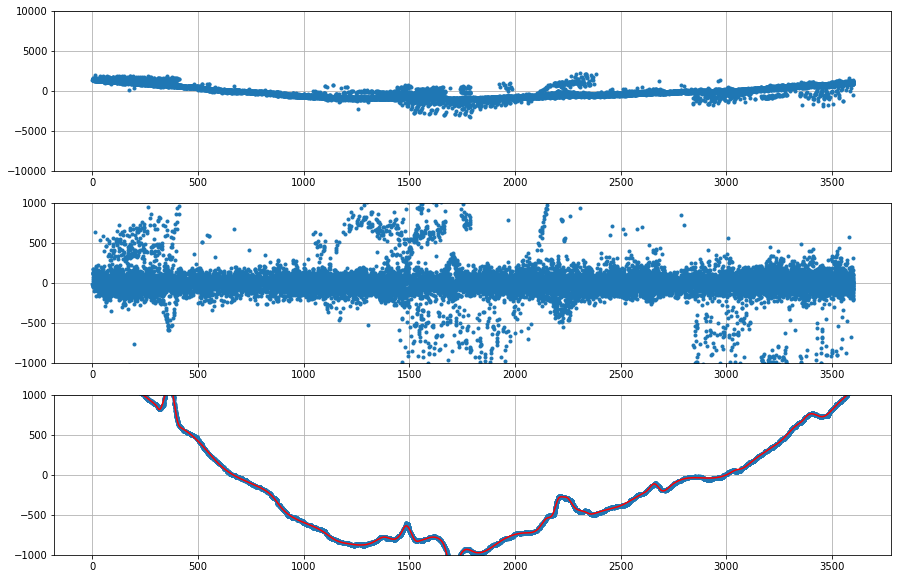

In [298]:
sss.check_result()

In [299]:
sss.save()

In [614]:
all_stations = [int(key) for key in st_params] + [711]#[35, 135]#[705, 84, 282, 287, 493, 239, 711, 606, 682, 608, 318, 33, 135, 506, 30, 230, 35, 609, 380]
len(all_stations)

241

In [615]:
test = (pd.read_csv('test_data.csv')
        .assign(num0 = lambda x: [len([w[0] for w in eval(meas) if w[0] in all_stations]) for meas in x.measurements])
       )

test[test.num0>=3].shape[0] / test.shape[0]

0.615527418427256

In [158]:
# 0.6155258384786991
import seaborn as sns

<AxesSubplot:xlabel='num0', ylabel='count'>

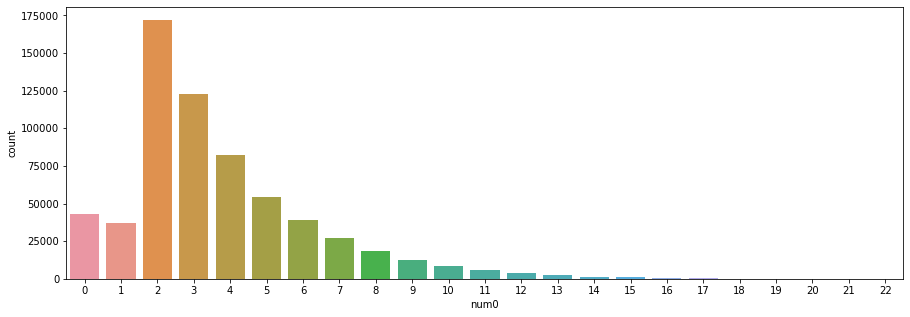

In [159]:
figsize(15, 5)
sns.countplot(test.num0)

In [175]:
test[test.num0>=3].shape[0] / test.shape[0]

0.6040206530875355

In [161]:
56% -> 64%
61% -> x

SyntaxError: invalid syntax (<ipython-input-161-d3960ab070d8>, line 1)

In [239]:
0.61*0.64/0.56

0.6971428571428572